In [1]:
import aquapointer
from aquapointer.density_canvas.DensityCanvas import DensityCanvas, Lattice
from aquapointer.density_canvas.norms import Lp_distance, KL_distance, JS_distance
import numpy as np
import matplotlib.pyplot as plt
import json
from pulser import Register, Sequence, Pulse
from pulser.waveforms import InterpolatedWaveform
from pulser.devices import MockDevice
from pulser_simulation import QutipEmulator

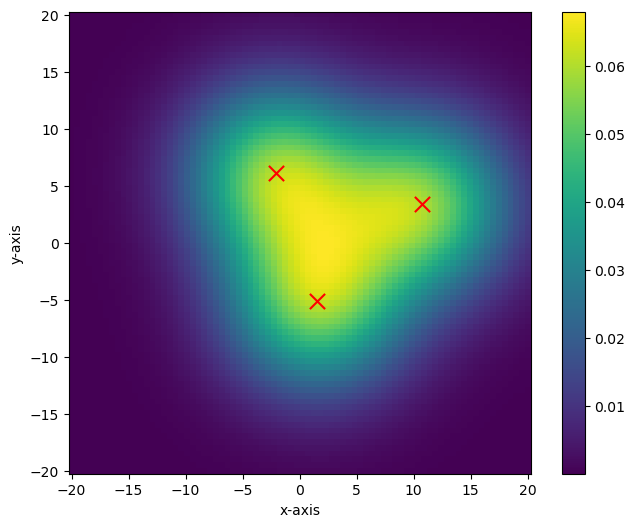

In [2]:
# Define empty canvas
origin = (-20, -20)
length = 40
npoints = 80
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)

# Fill canvas with random gaussian mixture
seed = 18389
n_centers = 3 #number of Gaussians
min_dist = 6 #minimal distance between gaussians
padding = 8 #minimal distance of Gaussian centers from border
amplitude = 10 #amplitude of the Gaussians
variance = 30 #variance of the Gaussians

canvas.set_randomized_gaussian_density(
    n_centers = n_centers,
    amplitude = amplitude,
    variance = variance,
    minimal_distance = min_dist,
    padding = padding,
    seed = seed
)

canvas.draw(draw_centers=True, figsize=(8,6))

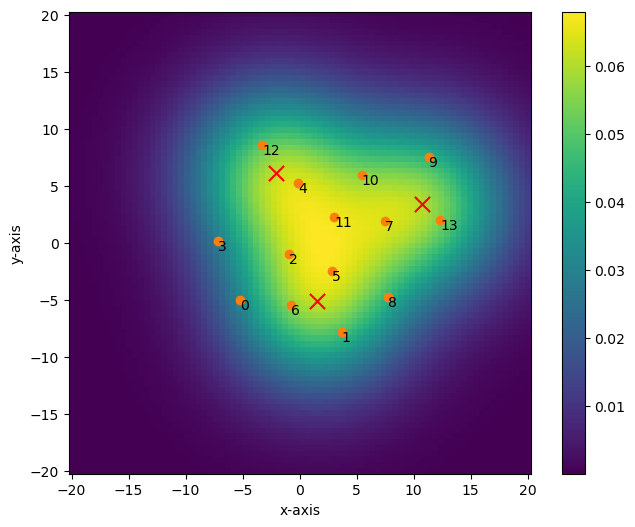

In [3]:
# Define a Poisson lattice
canvas.set_poisson_disk_lattice(spacing=(4,6))

# Calculate QUBO
canvas.calculate_pubo_coefficients(2, [amplitude, variance])

# Reduce number of variables
canvas.force_lattice_size(14)

canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

In [4]:
# Calculate detunings
detunings = canvas.calculate_detunings()
detunings

{0: 3.7326704732503018,
 1: 5.086691805799822,
 2: 8.134539755202924,
 3: 3.812359326877336,
 4: 7.982147781508805,
 5: 8.615216823819472,
 6: 6.196254122214058,
 7: 8.428869299816515,
 8: 6.022010989351744,
 9: 4.501399383613384,
 10: 7.767233497860445,
 11: 9.381756784474602,
 12: 4.976149925303843,
 13: 5.538827602791749}

In [5]:
# Find ground state with Pulser
MockDevice.change_rydberg_level(70)
reg = Register.from_coordinates(canvas._lattice._coords)
seq = Sequence(reg, MockDevice)
for i in range(len(detunings)):
    seq.declare_channel(f"ch{i}", "rydberg_local", i)
    omega_wf = InterpolatedWaveform(4000, [0, 10, 0])
    delta_wf = InterpolatedWaveform(4000, [-10, 0, detunings[i]]) 
    p = Pulse(omega_wf, delta_wf, 0)
    seq.add(p, f"ch{i}")
sim = QutipEmulator.from_sequence(seq, sampling_rate=.4)
res = sim.run()
samples = res.sample_final_state(1000)
samples = {k:samples[k] for k,v in sorted(samples.items(), key=lambda x: x[1], reverse=True)}

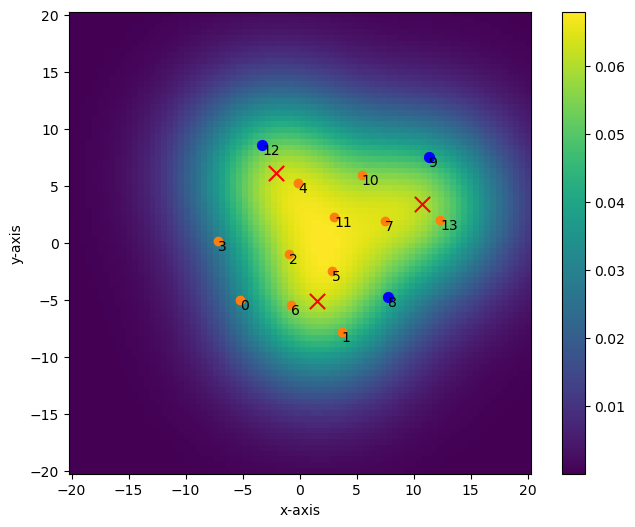

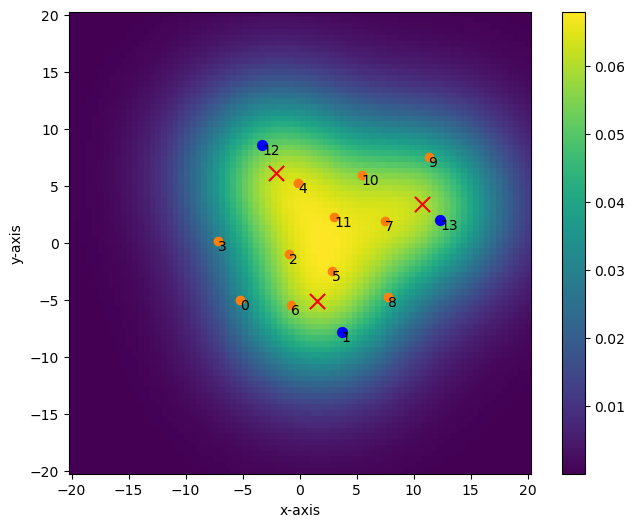

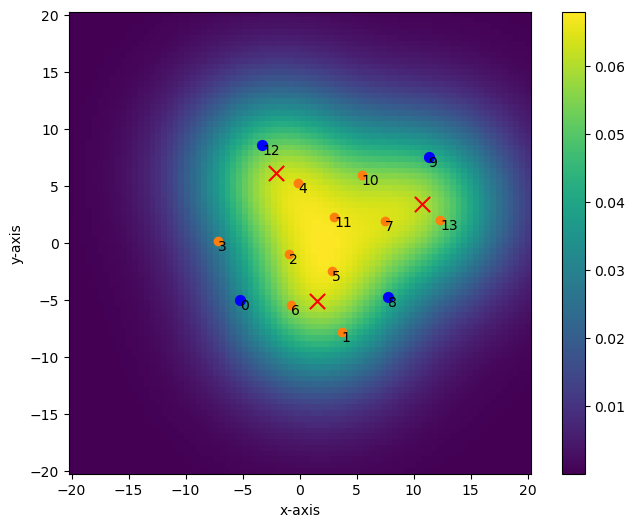

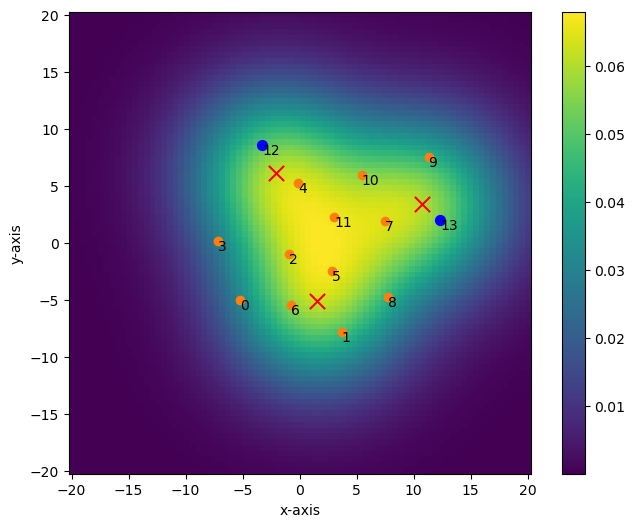

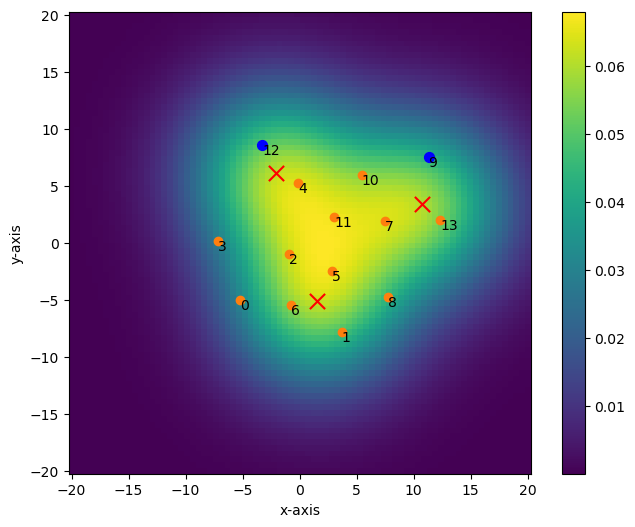

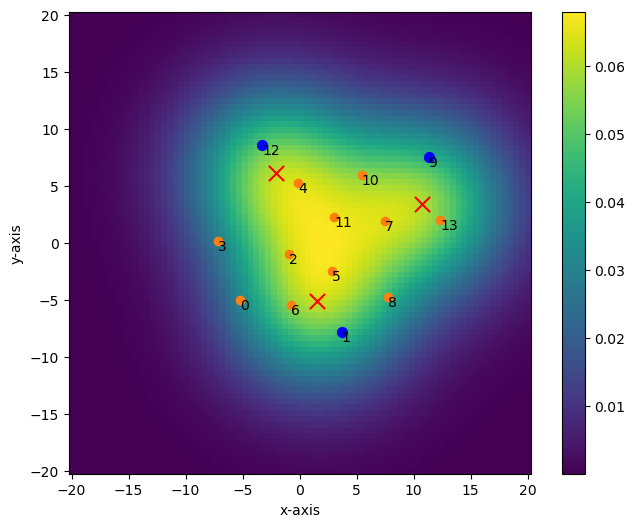

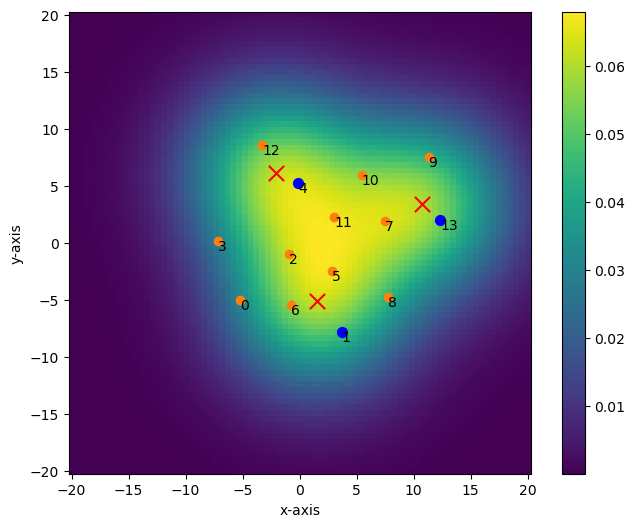

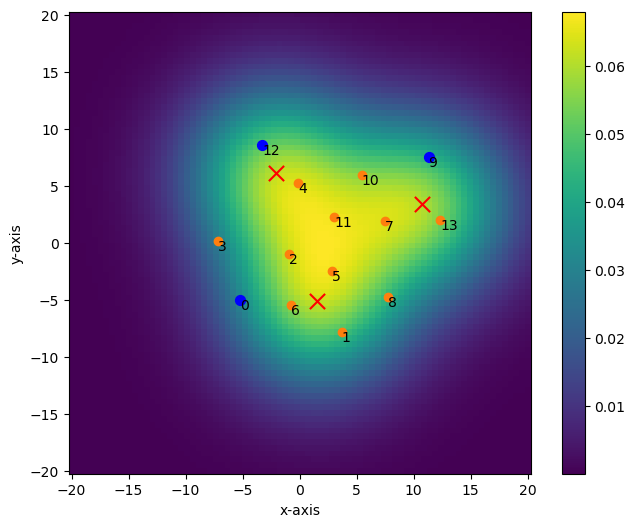

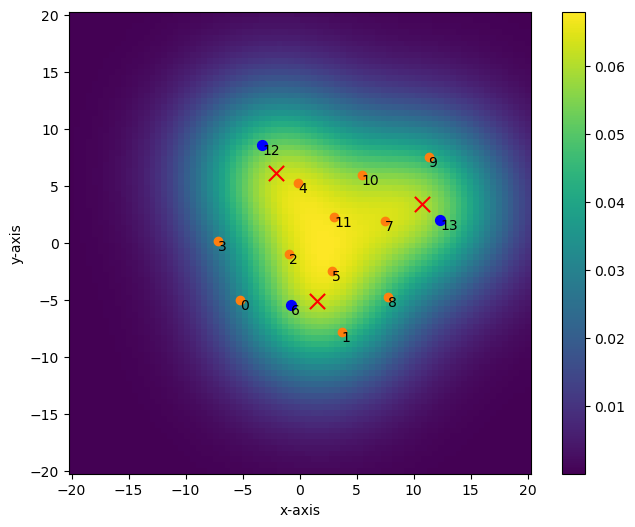

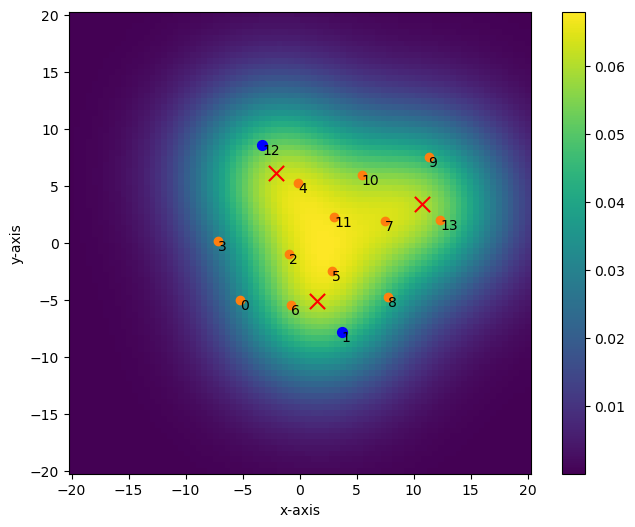

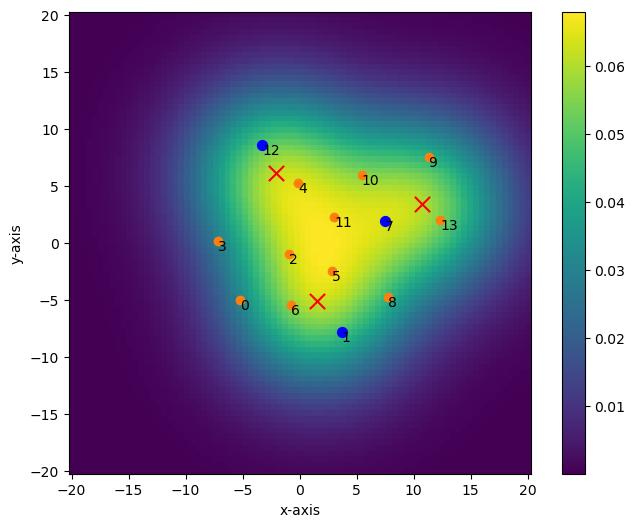

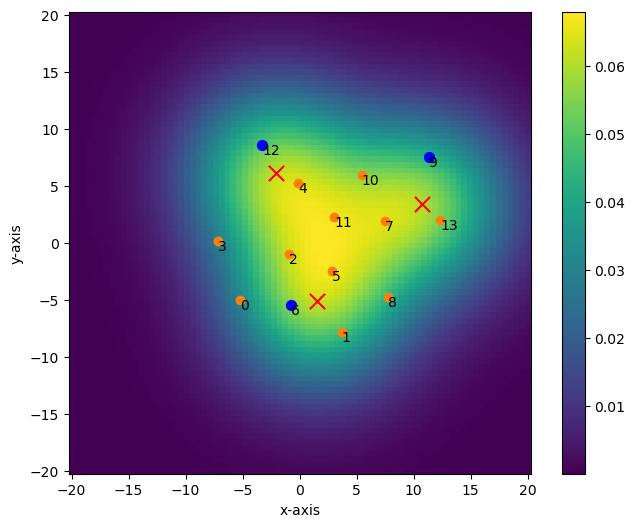

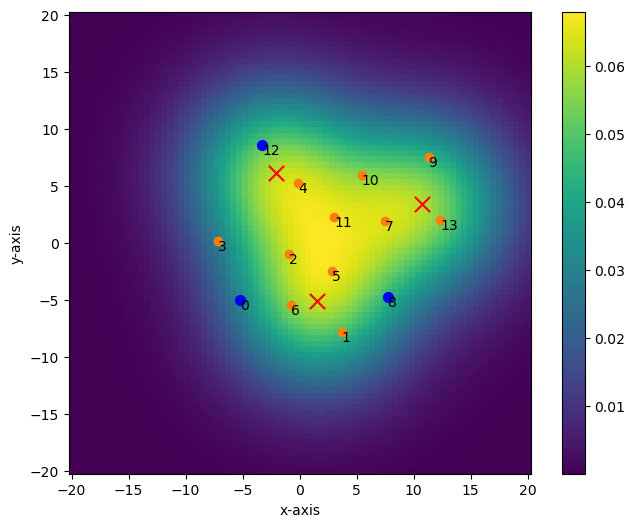

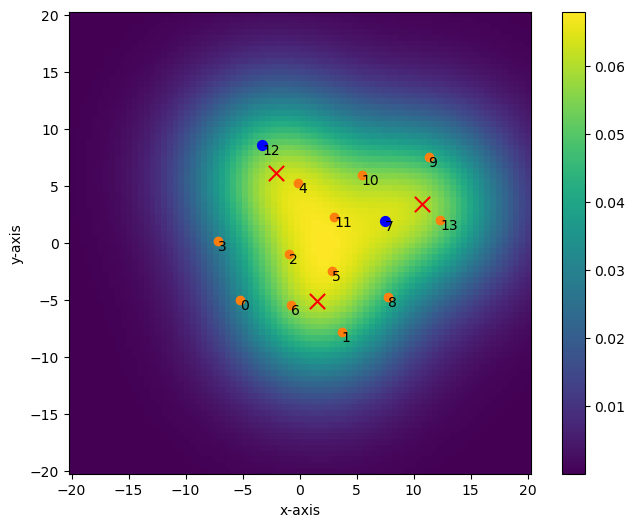

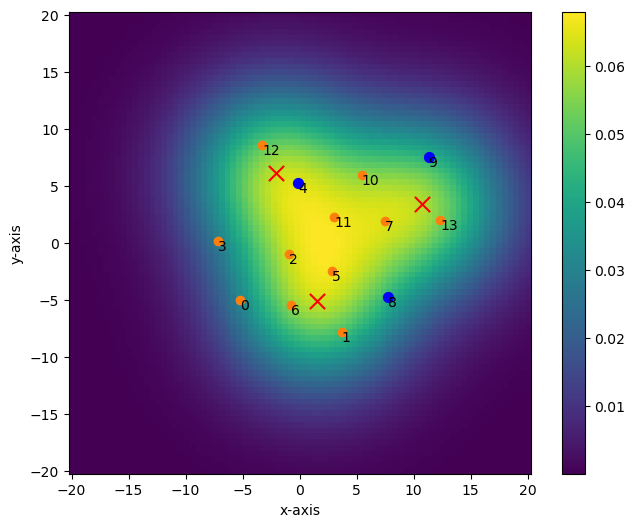

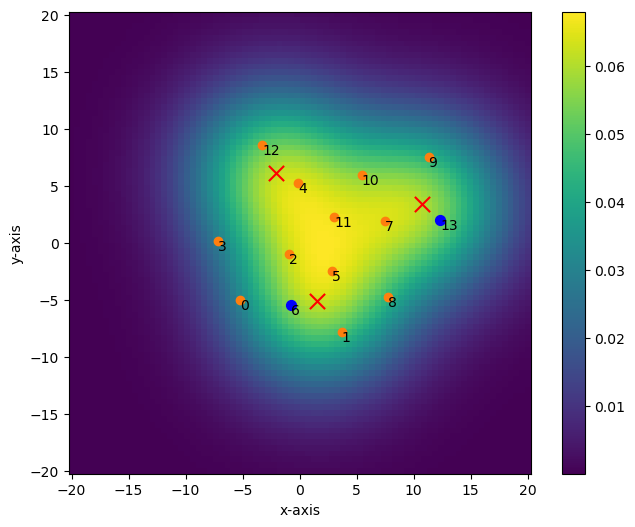

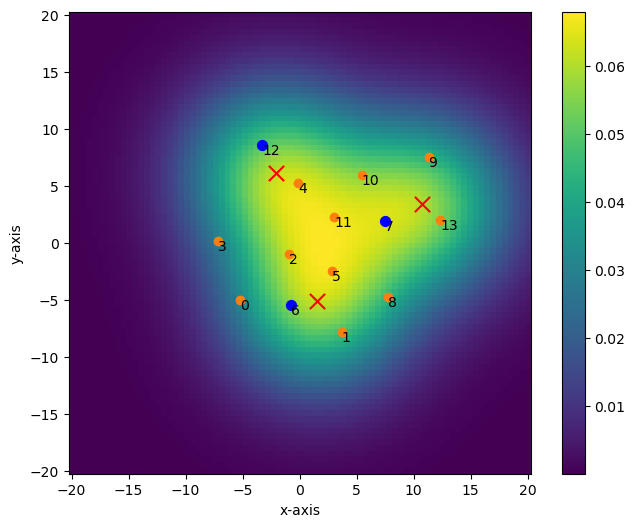

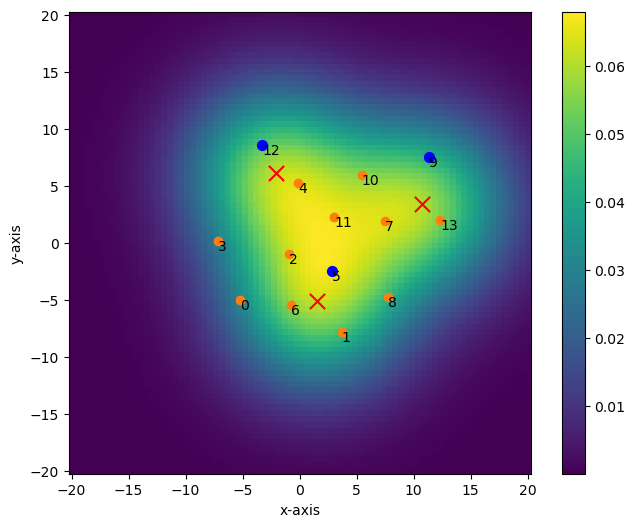

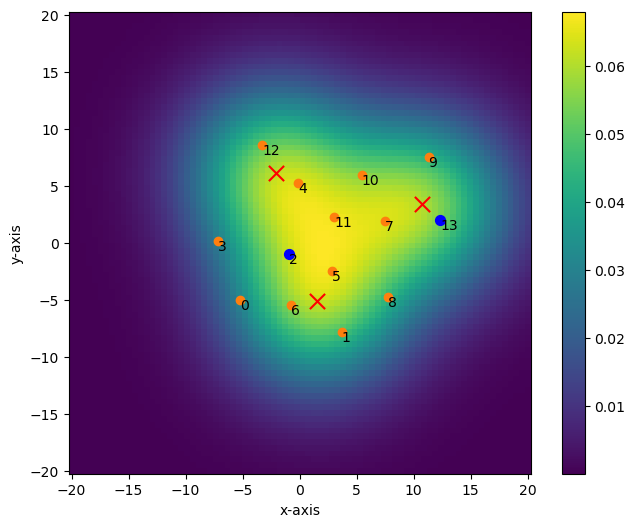

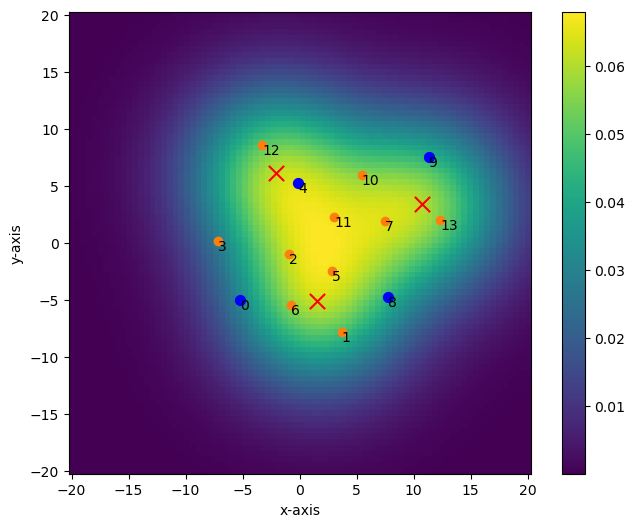

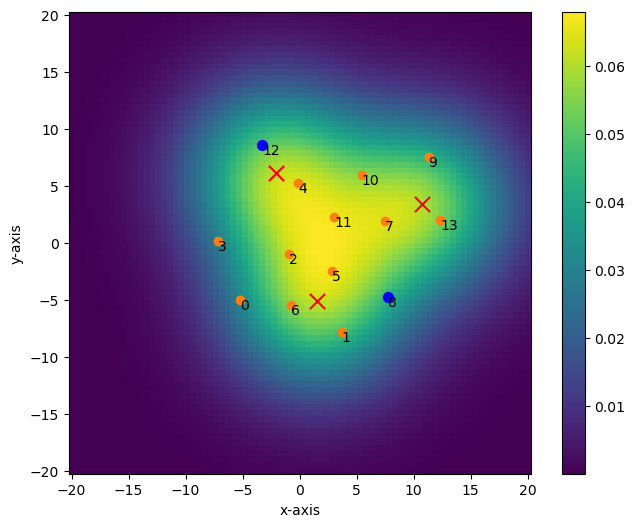

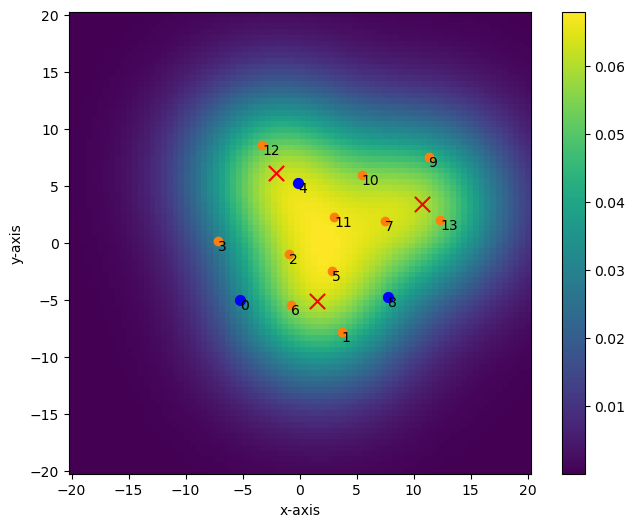

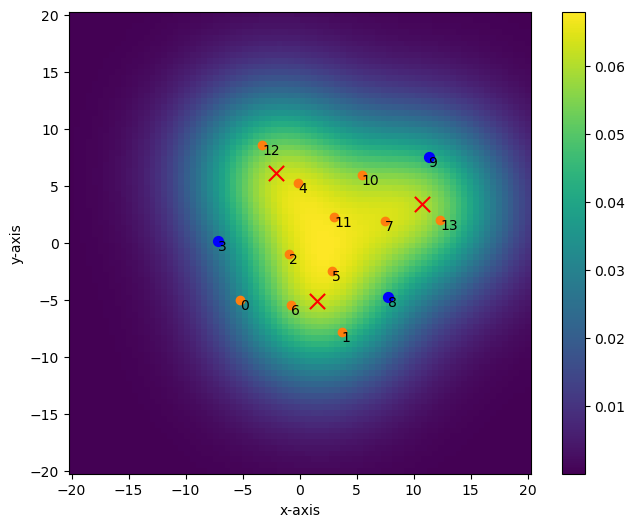

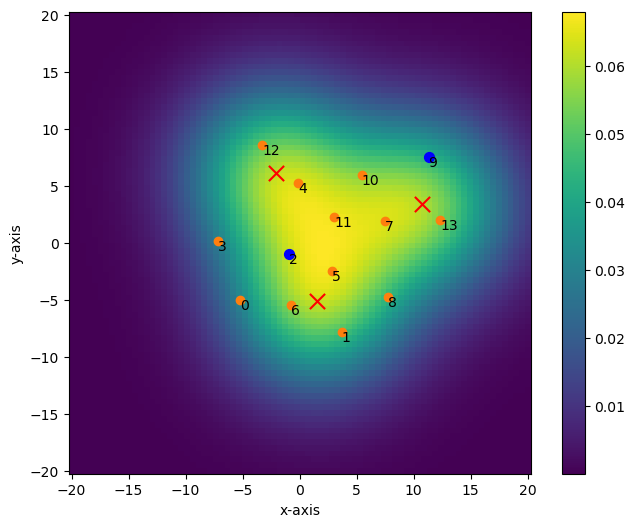

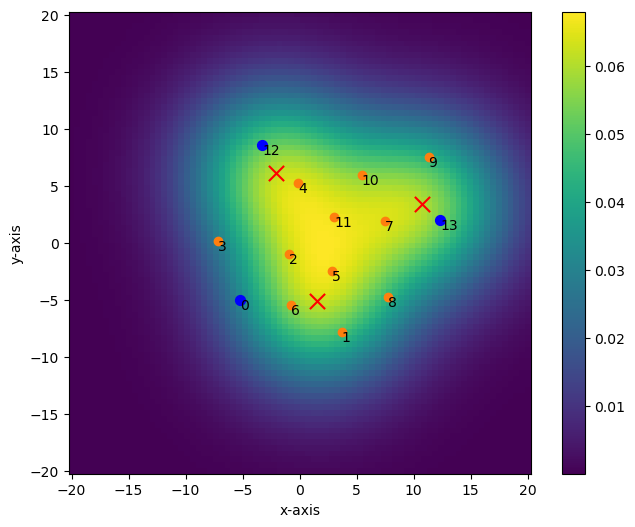

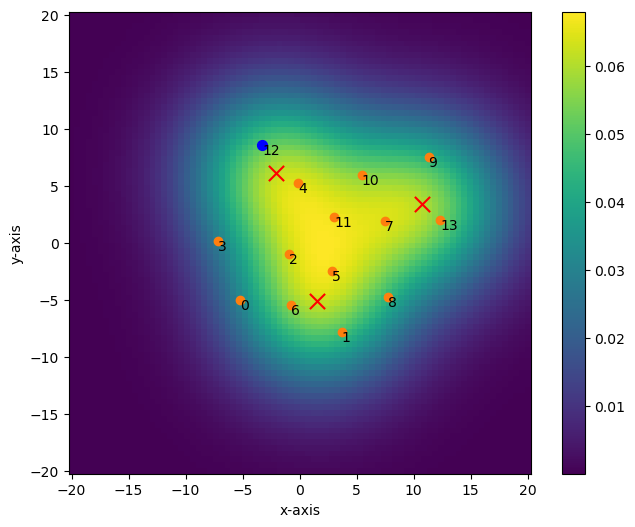

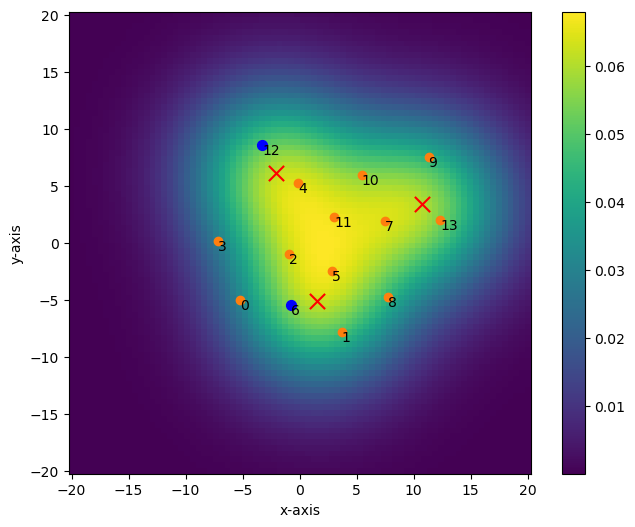

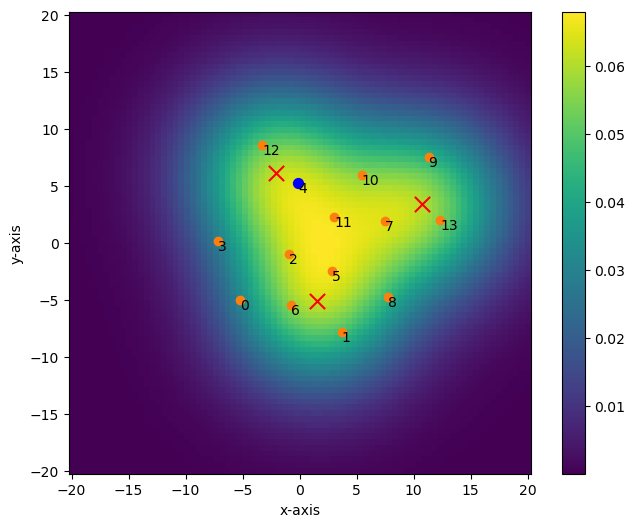

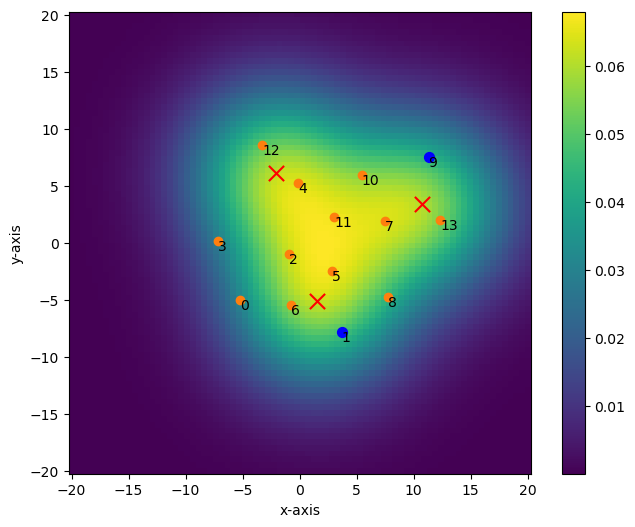

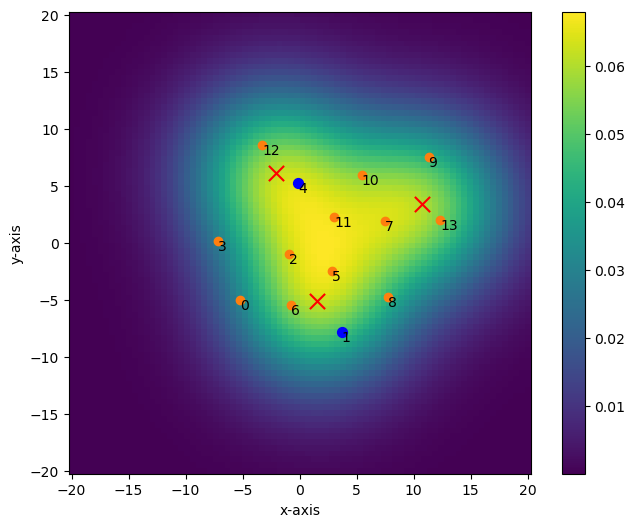

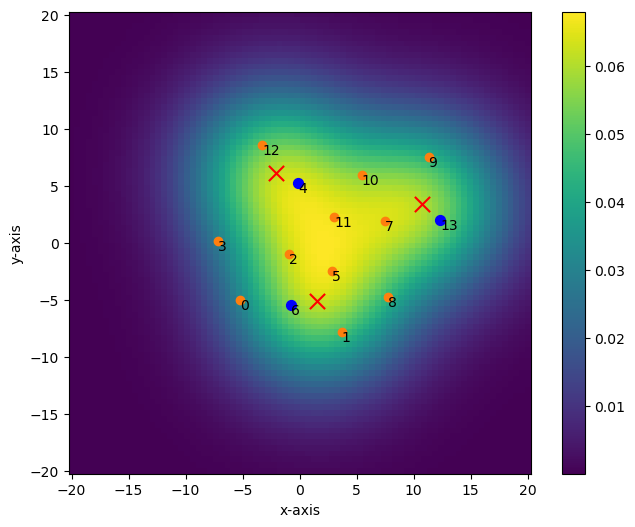

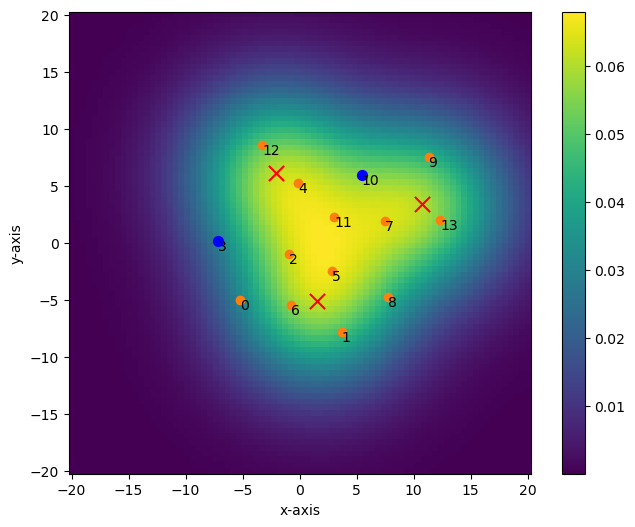

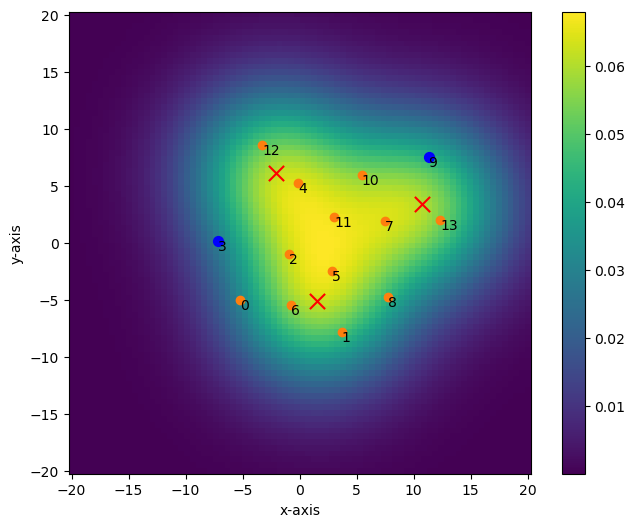

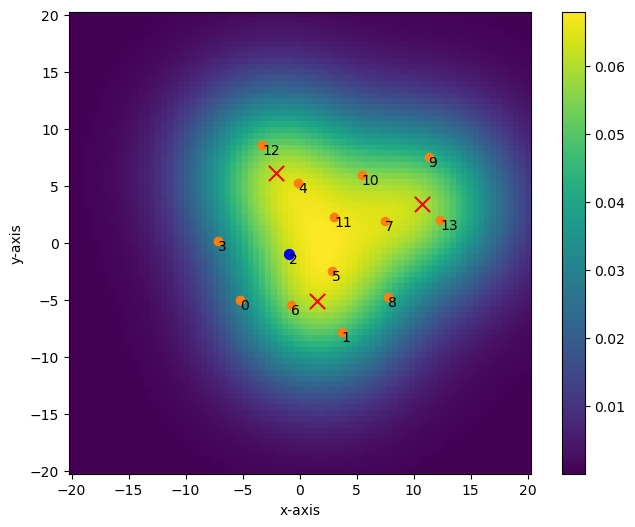

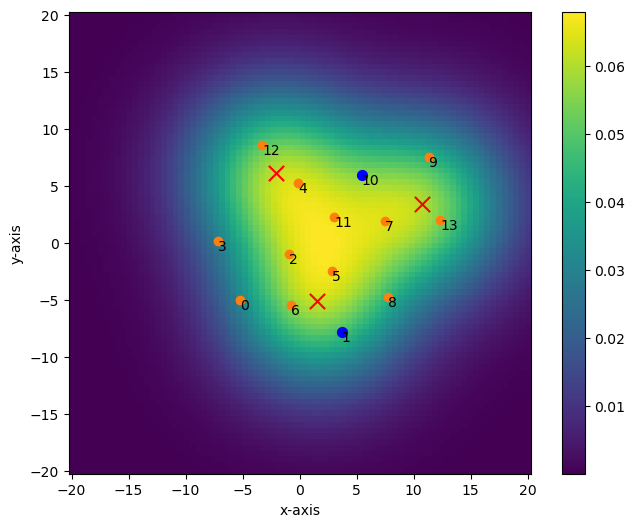

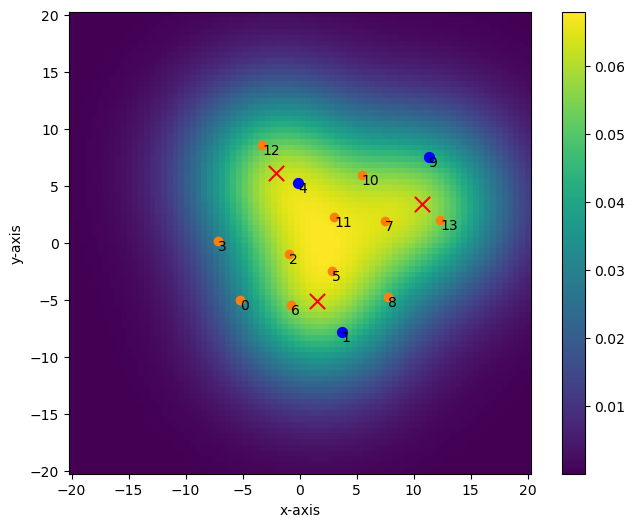

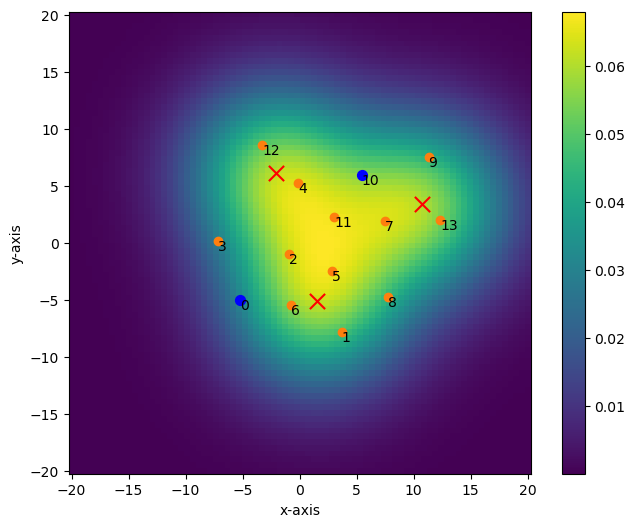

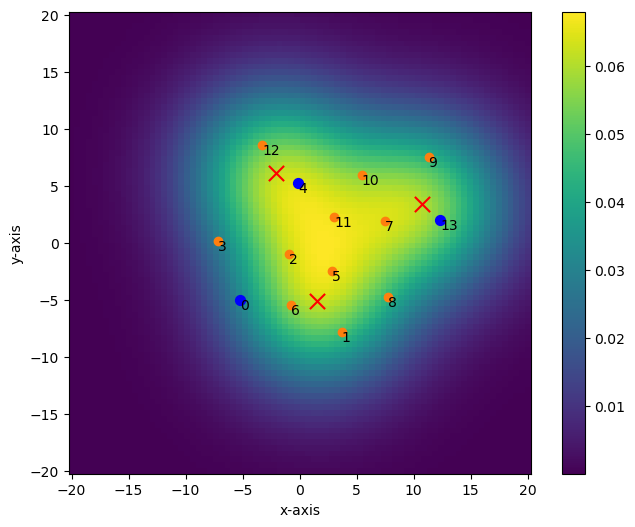

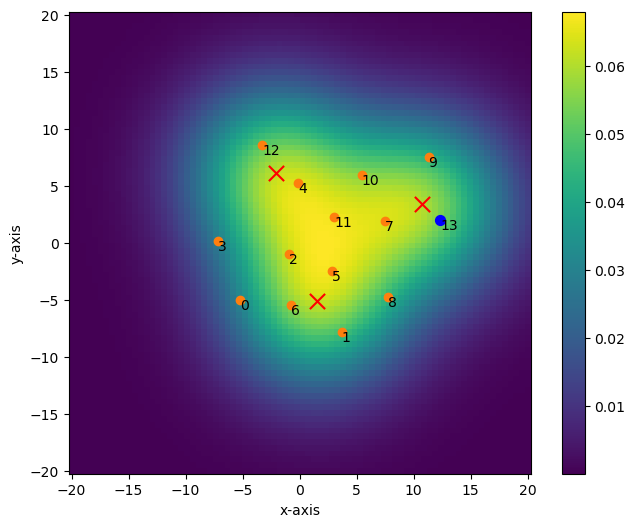

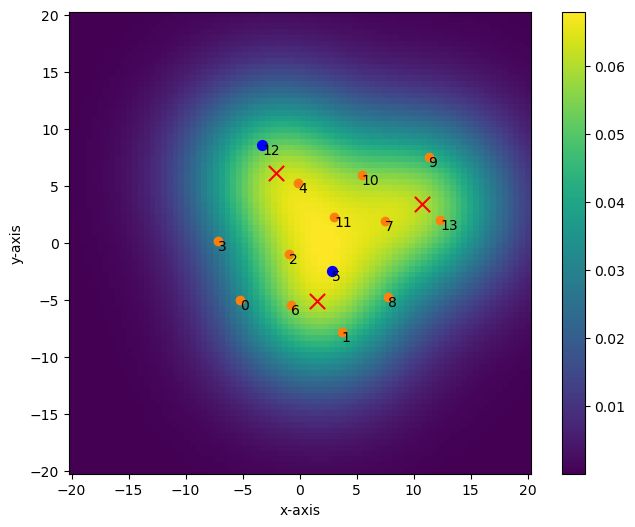

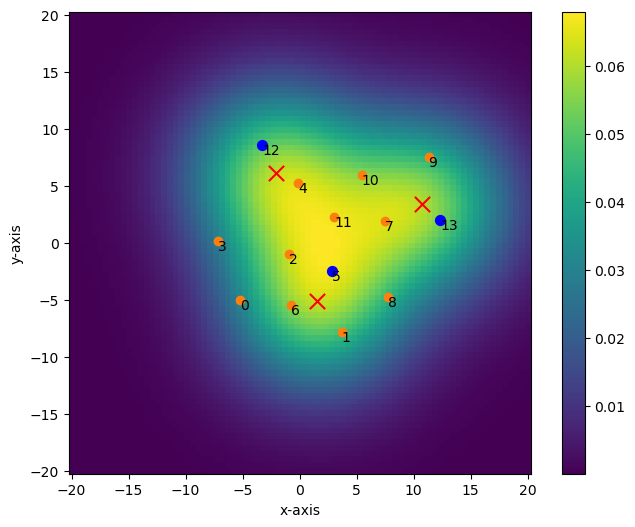

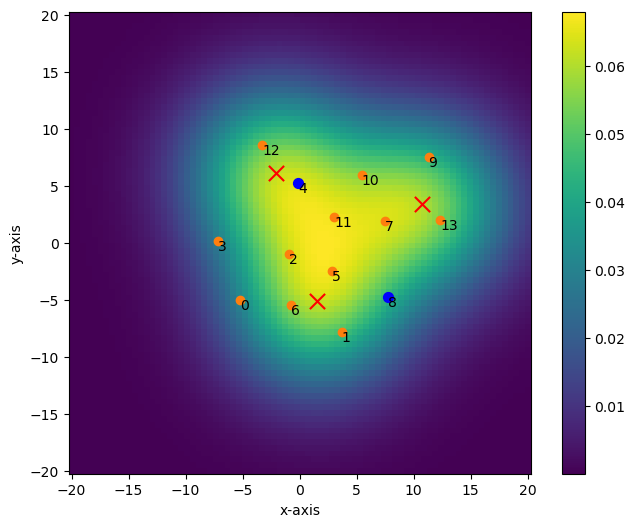

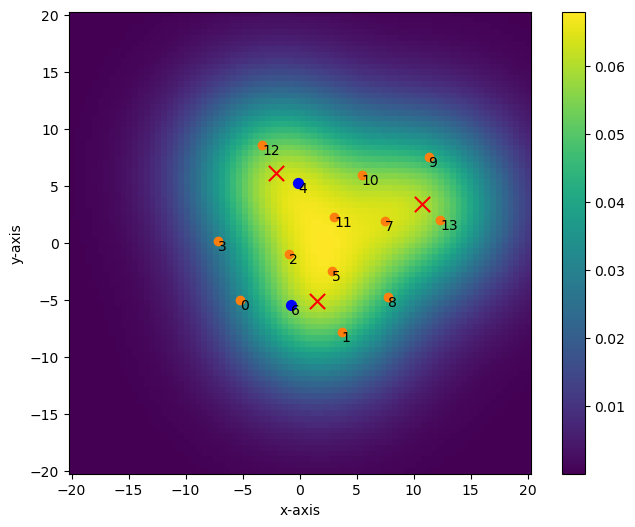

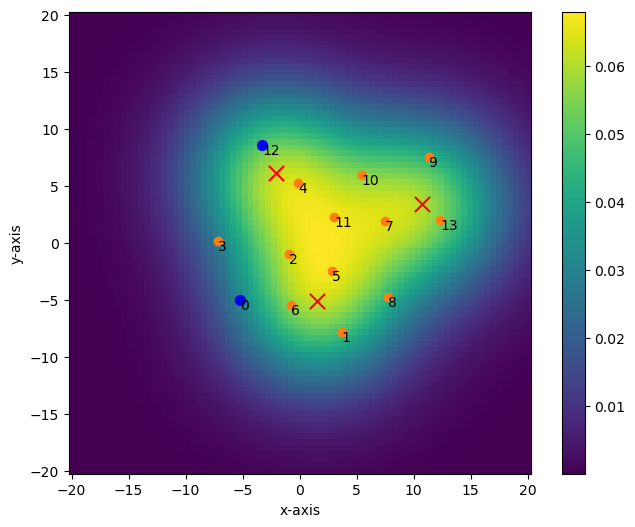

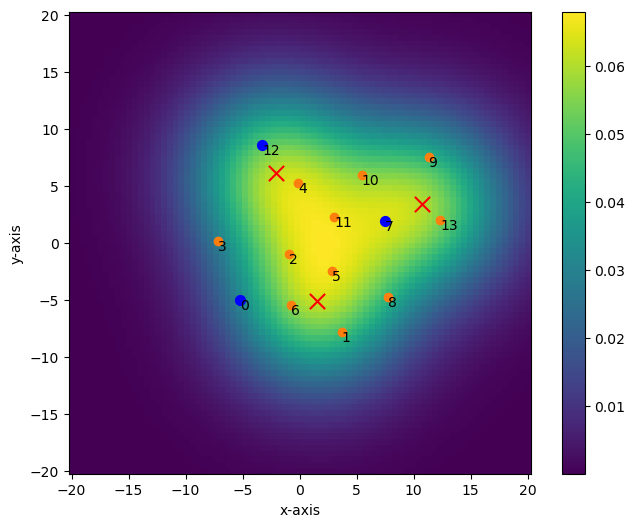

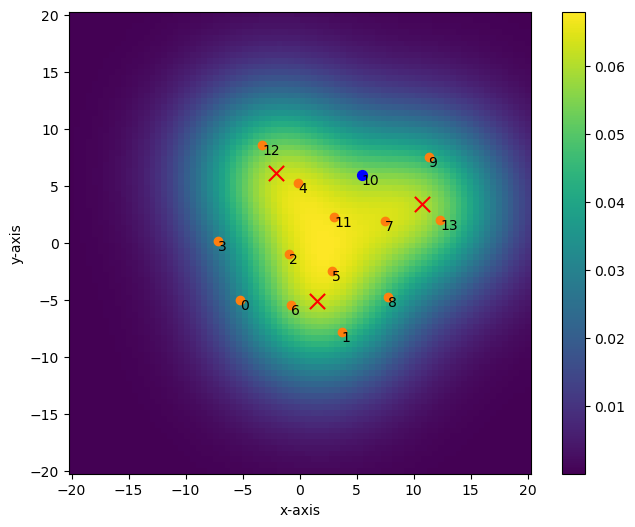

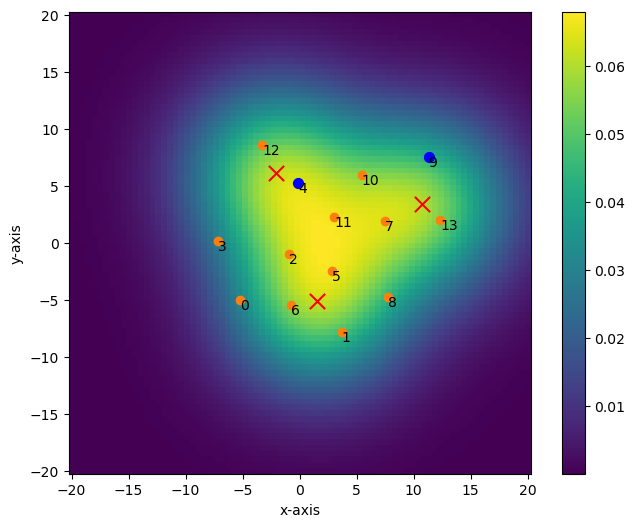

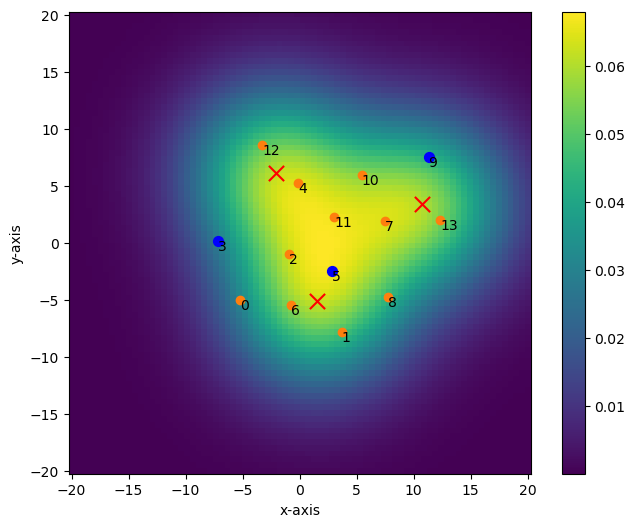

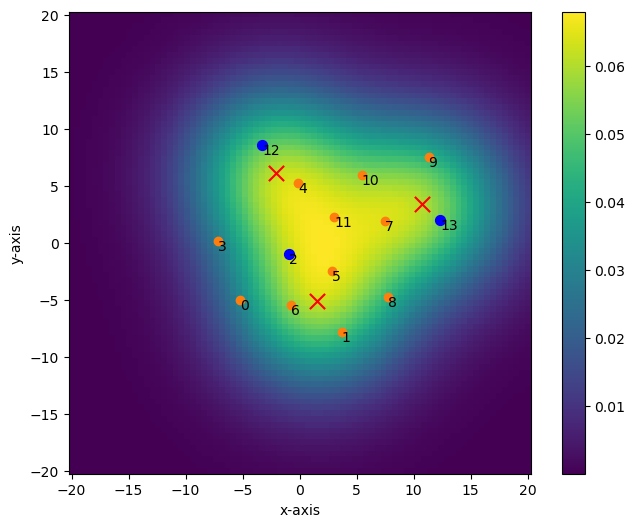

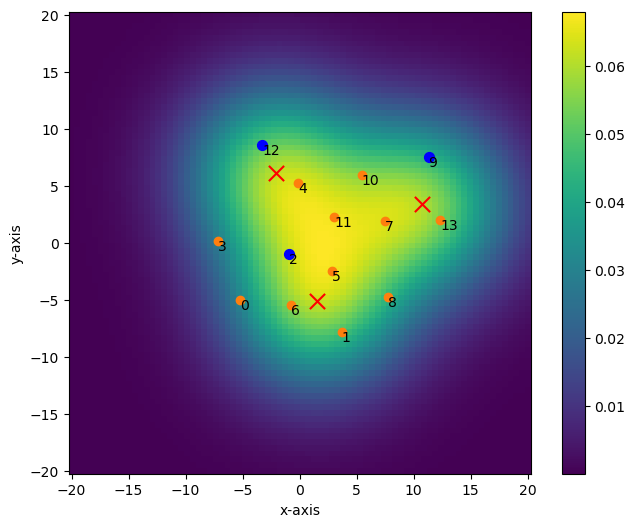

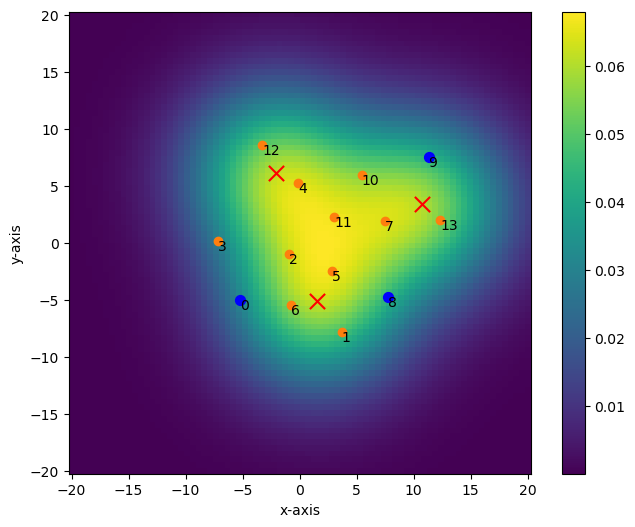

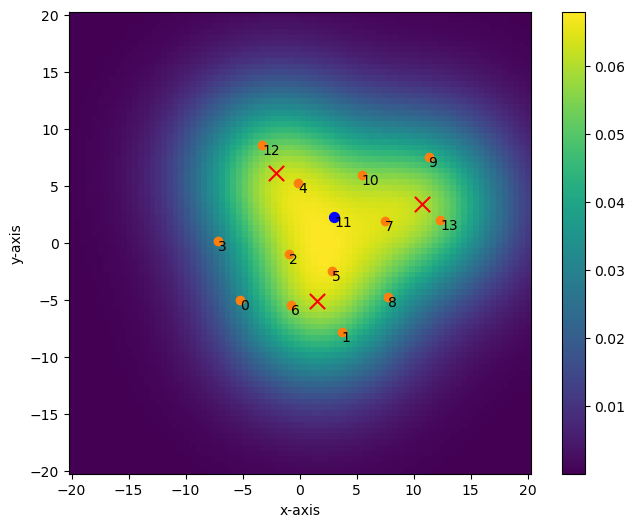

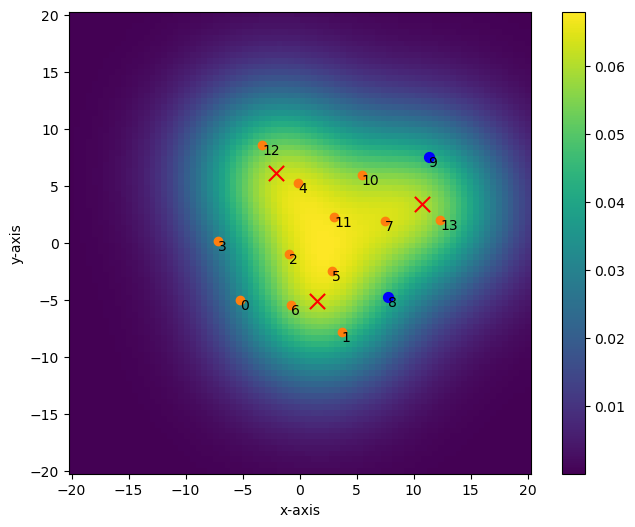

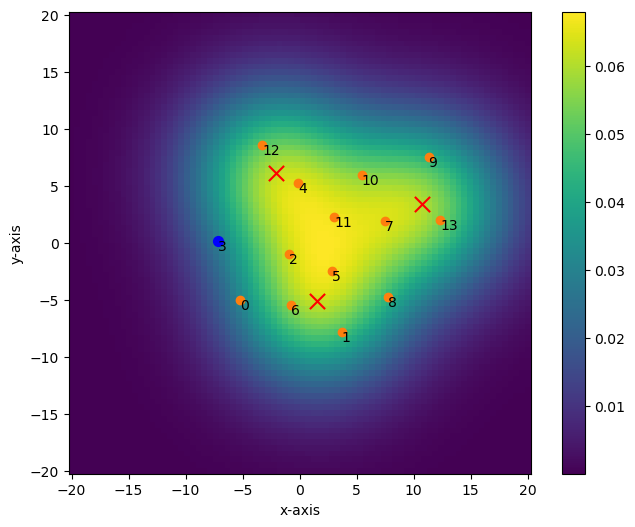

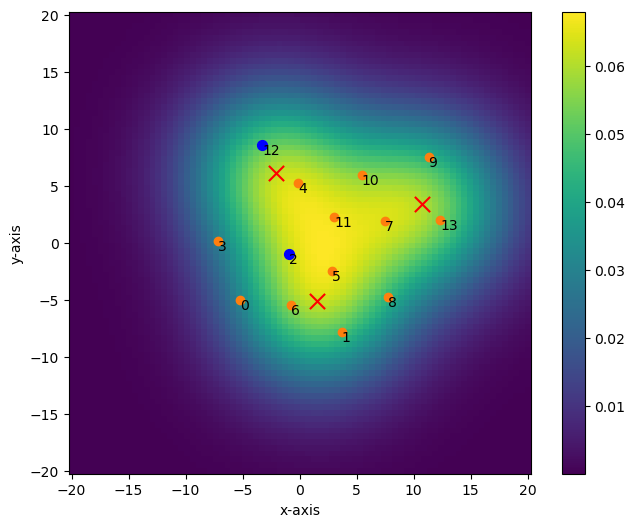

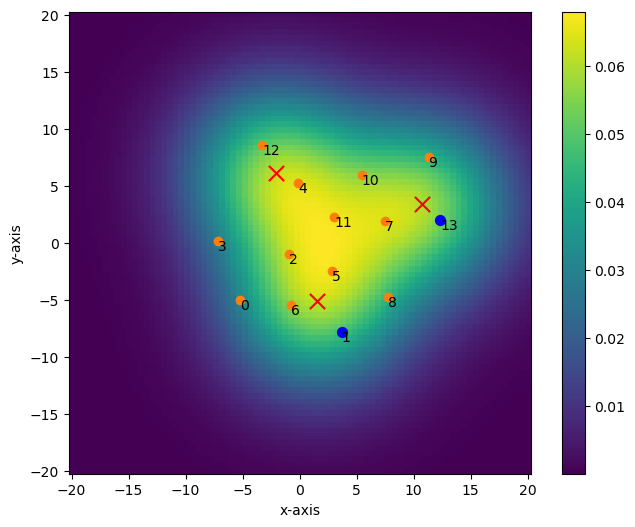

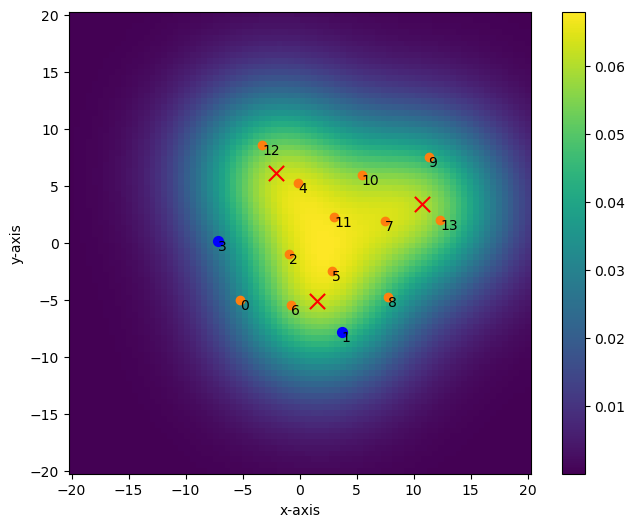

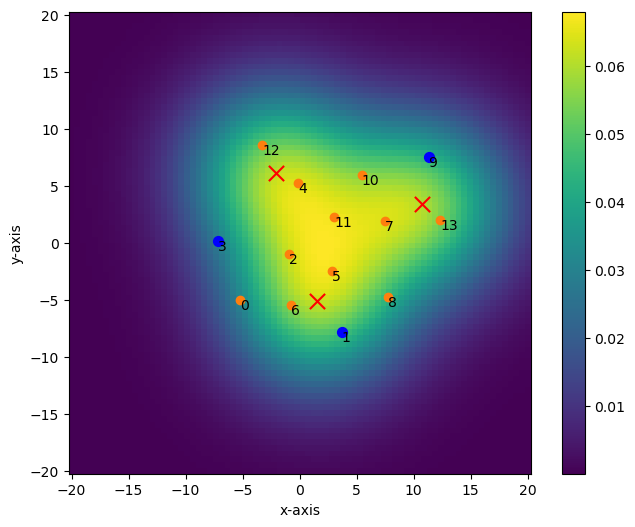

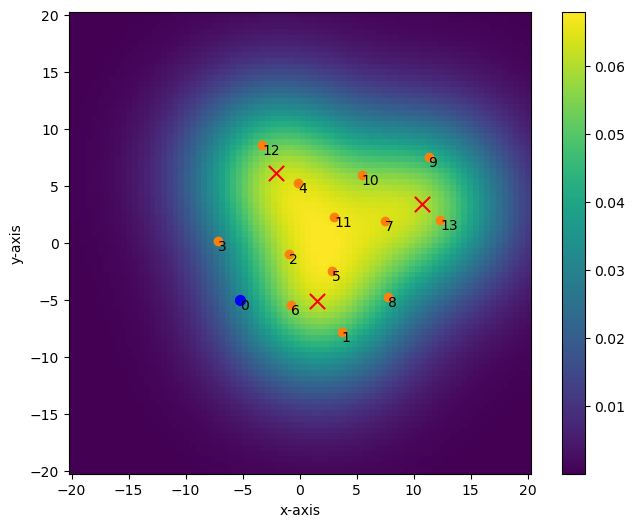

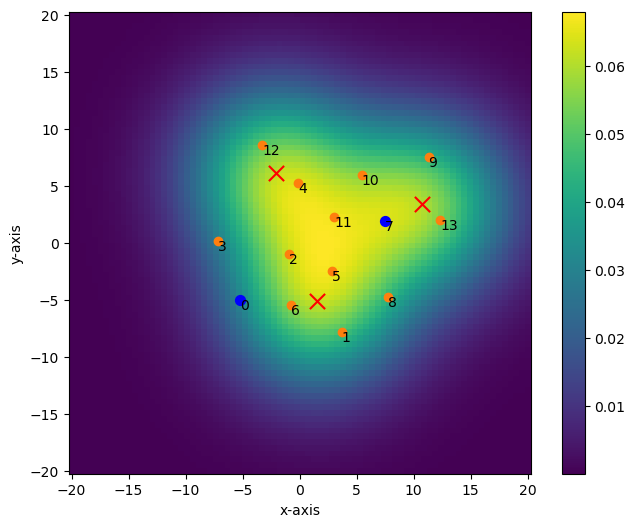

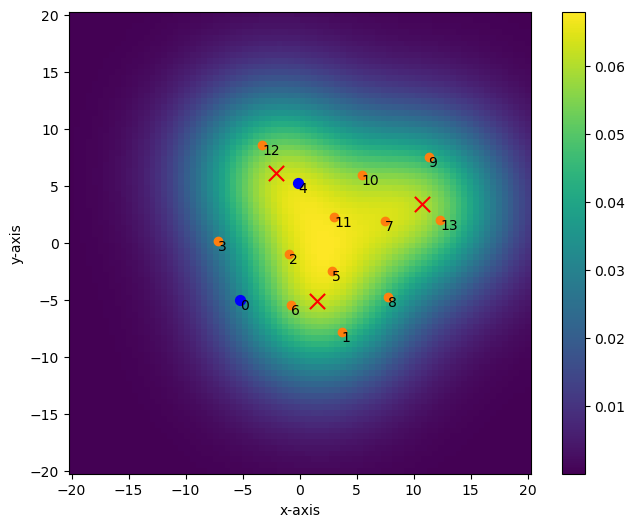

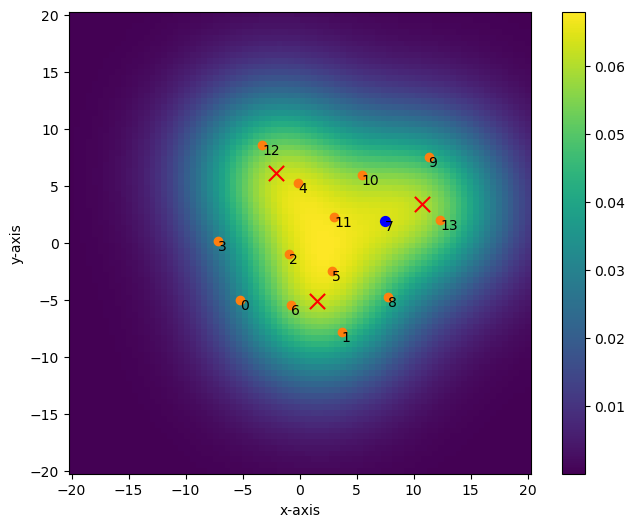

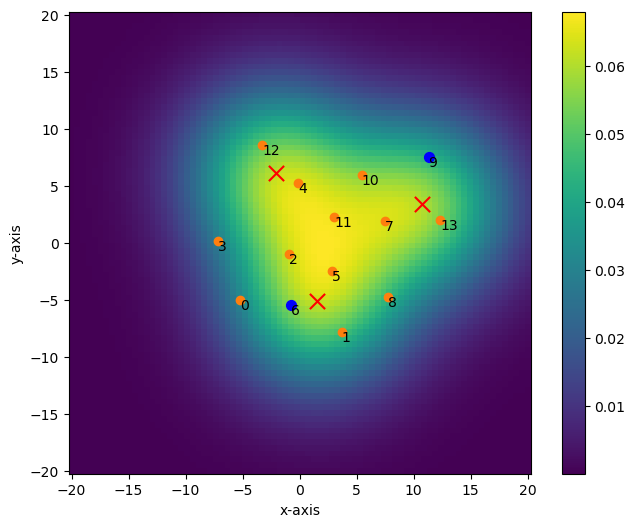

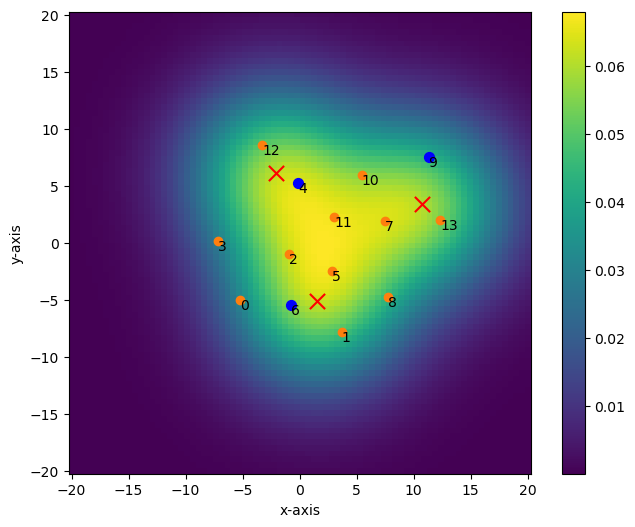

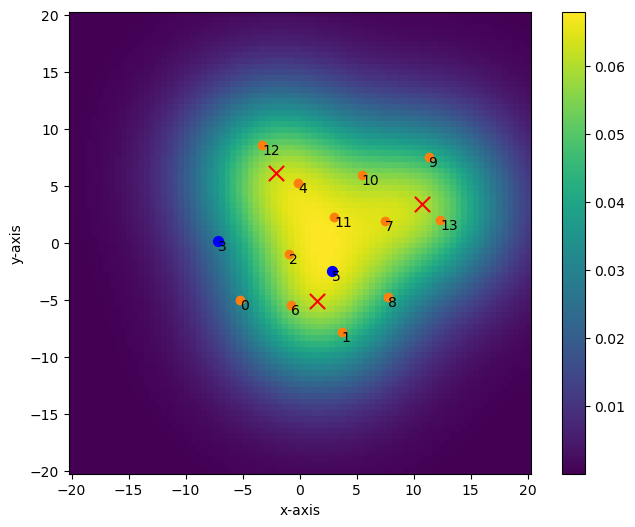

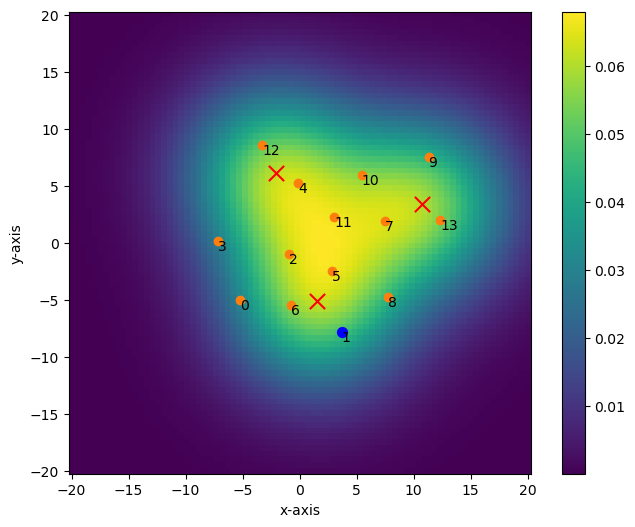

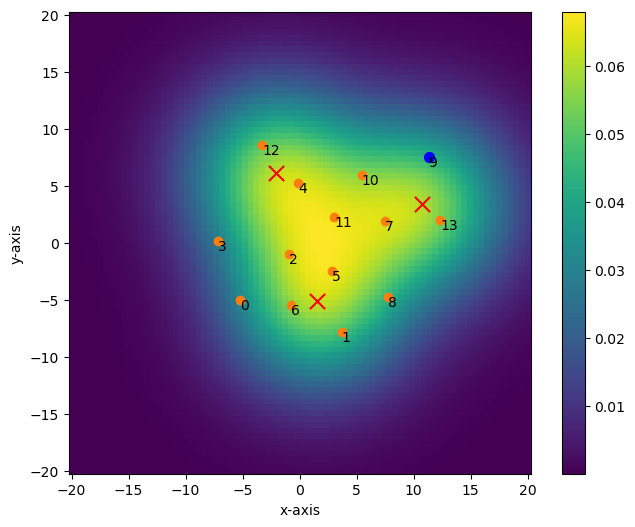

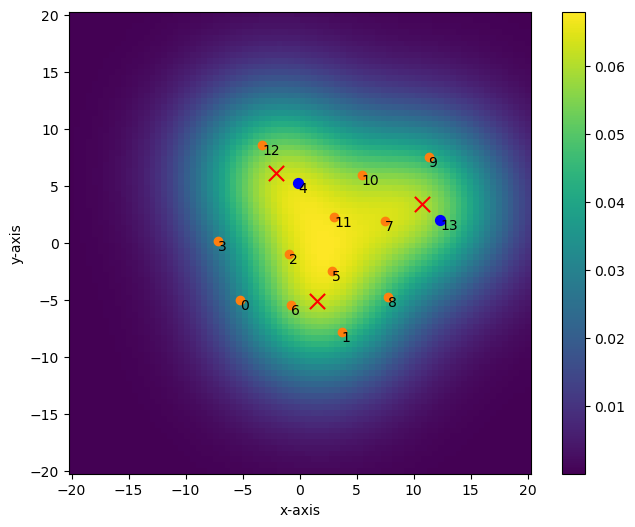

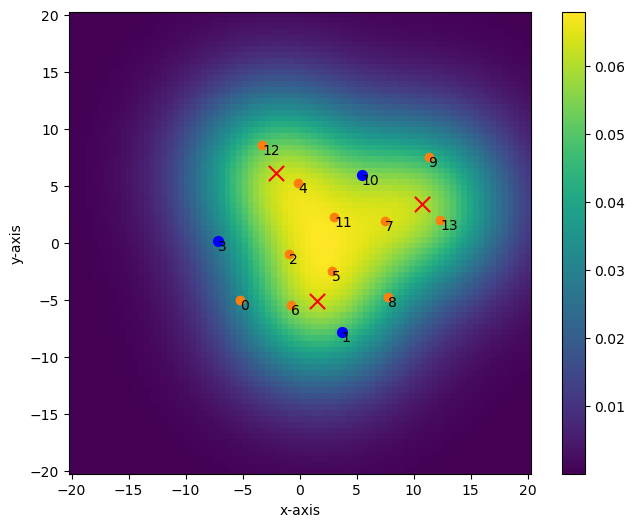

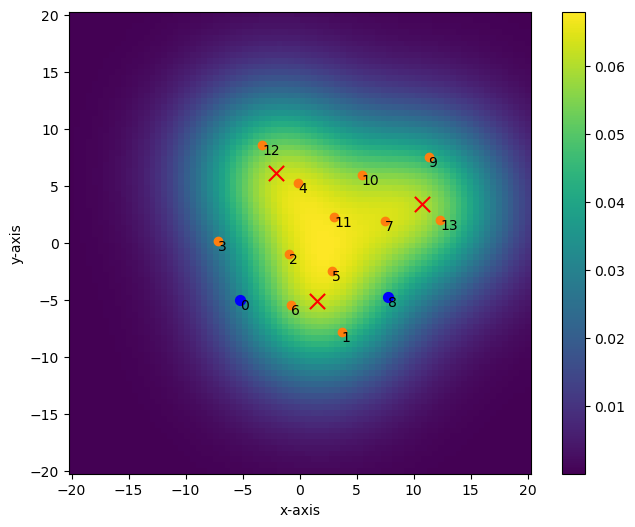

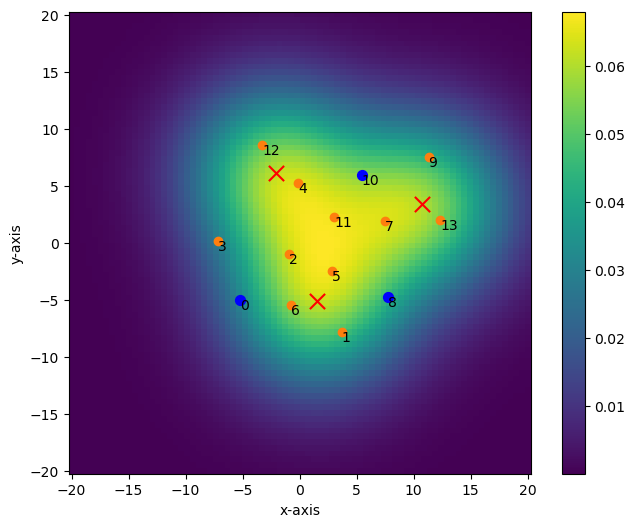

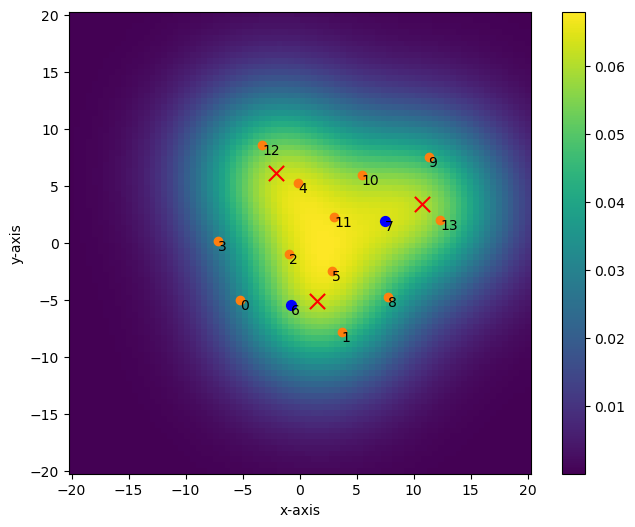

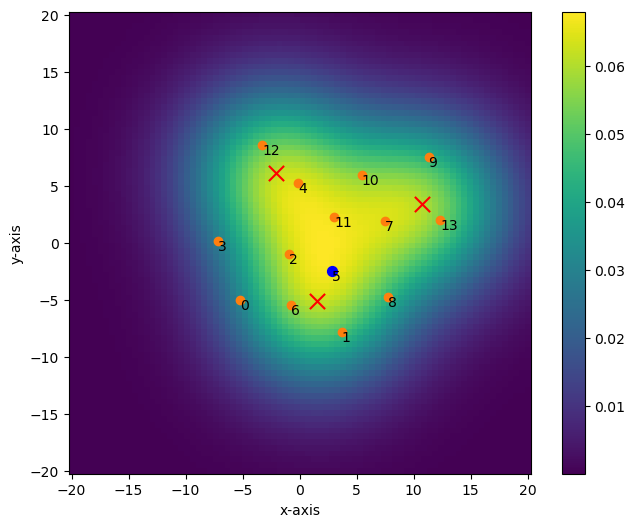

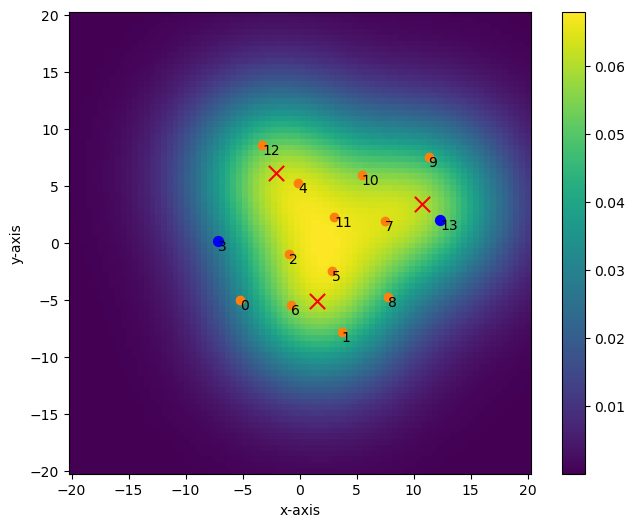

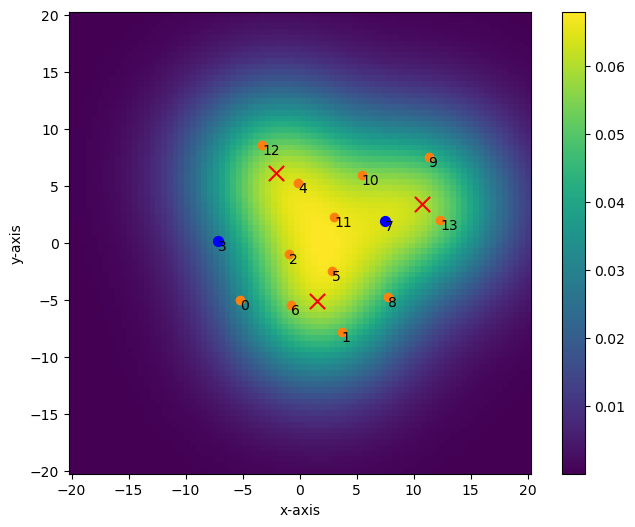

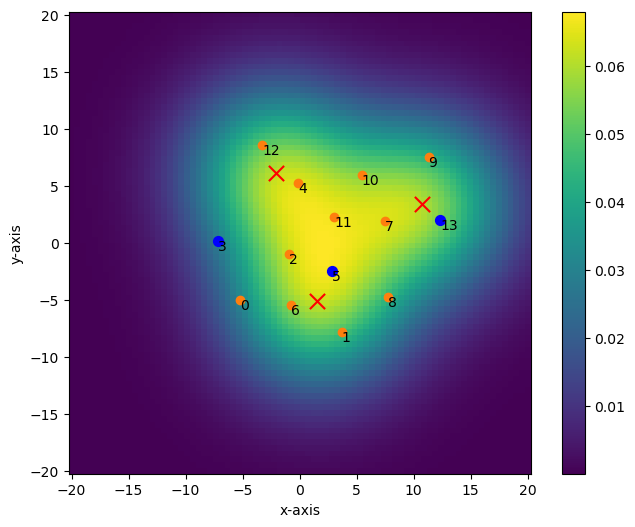

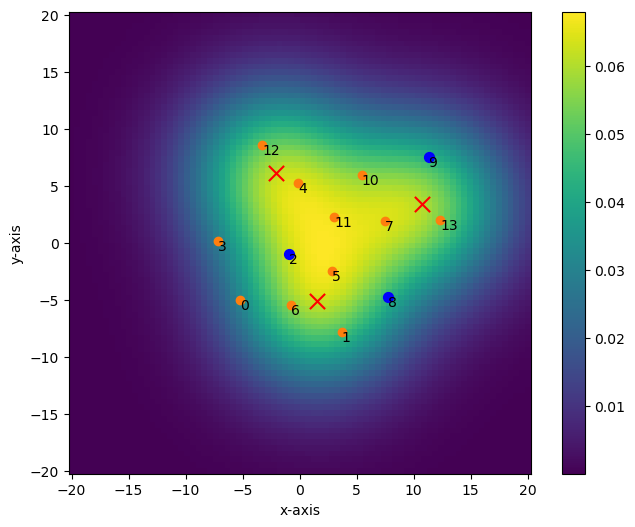

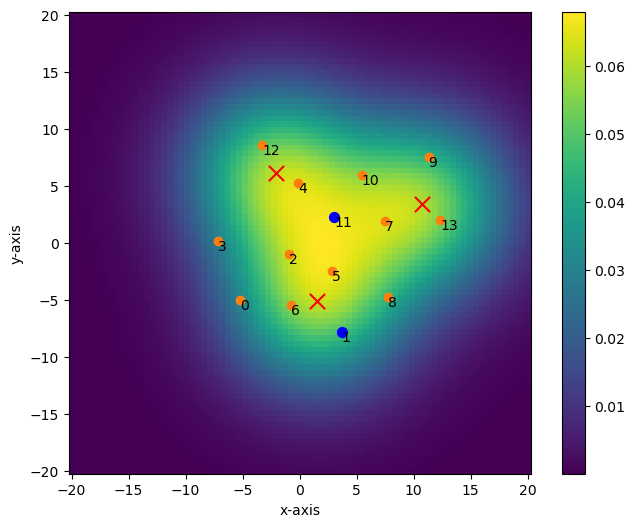

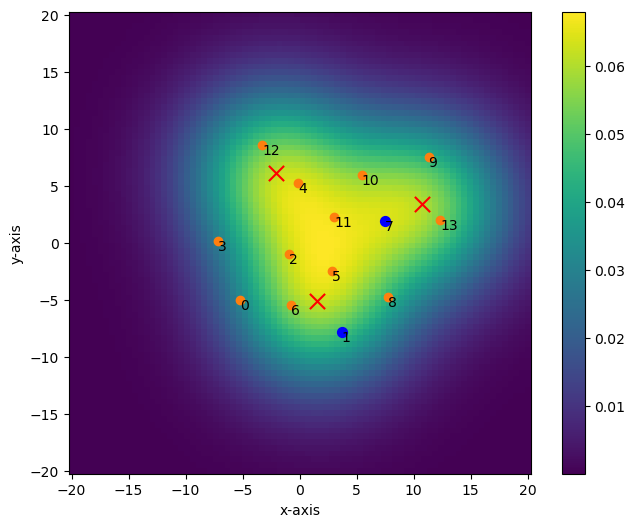

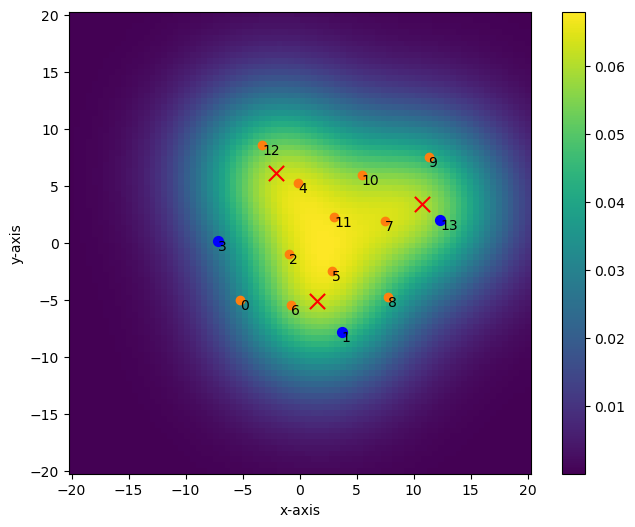

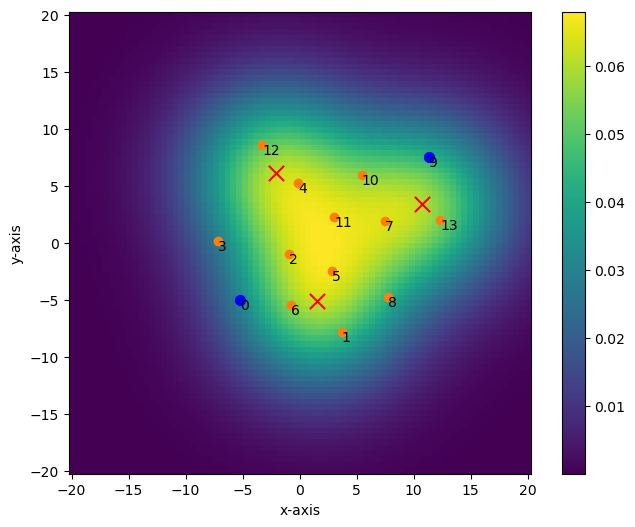

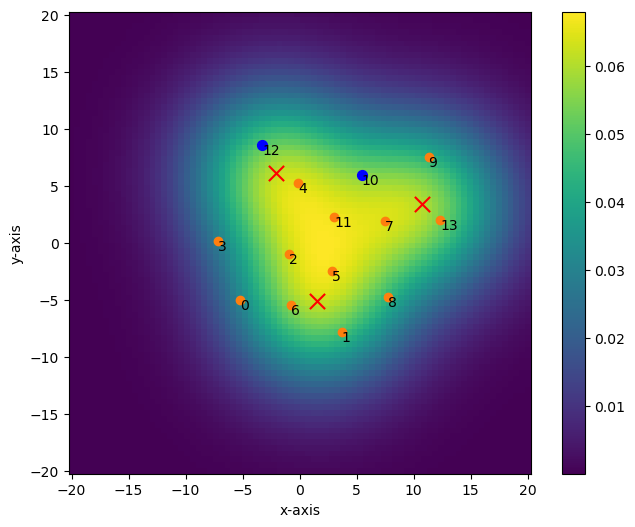

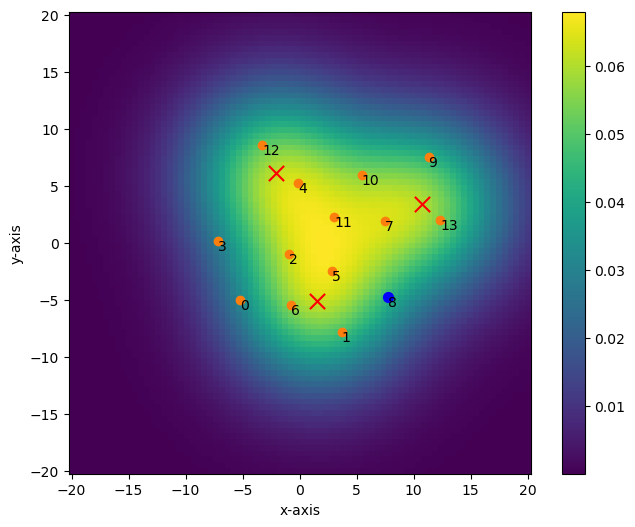

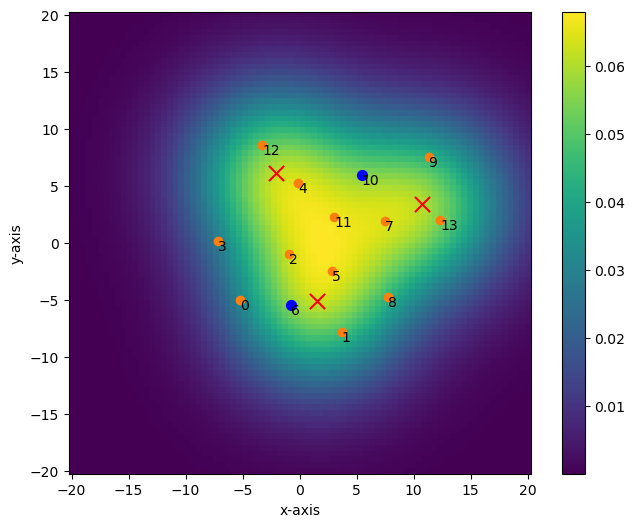

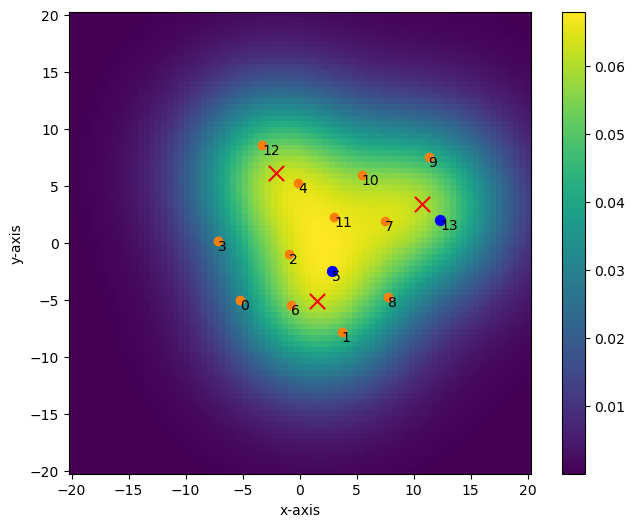

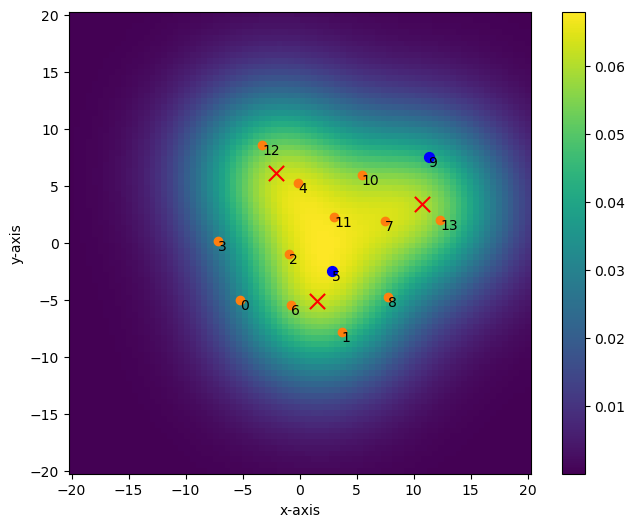

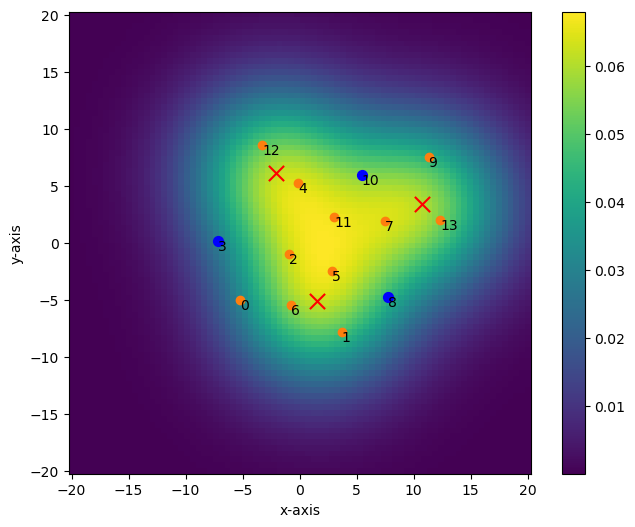

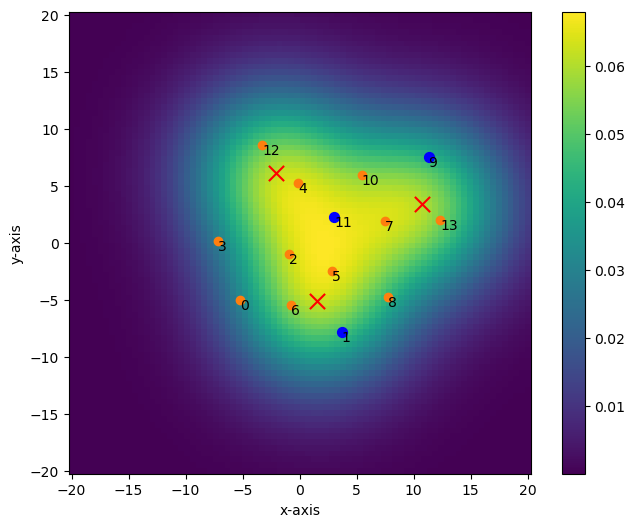

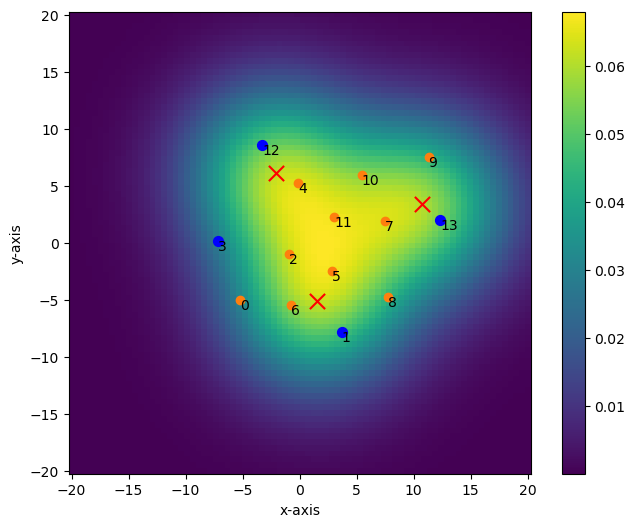

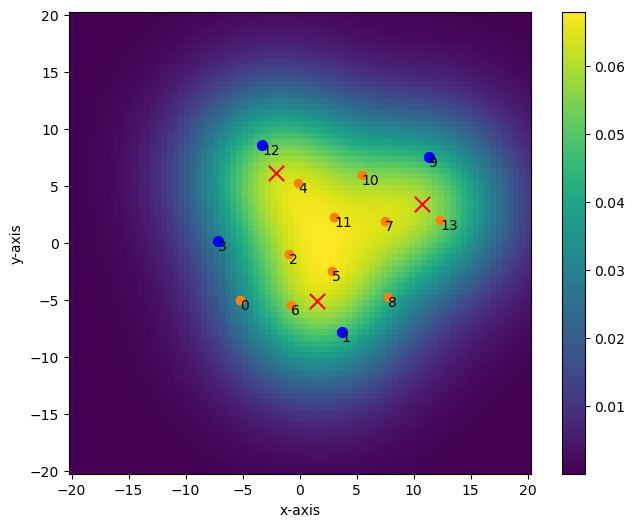

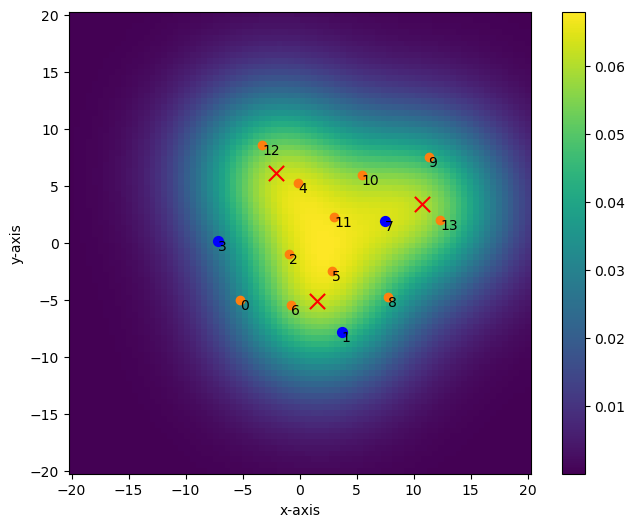

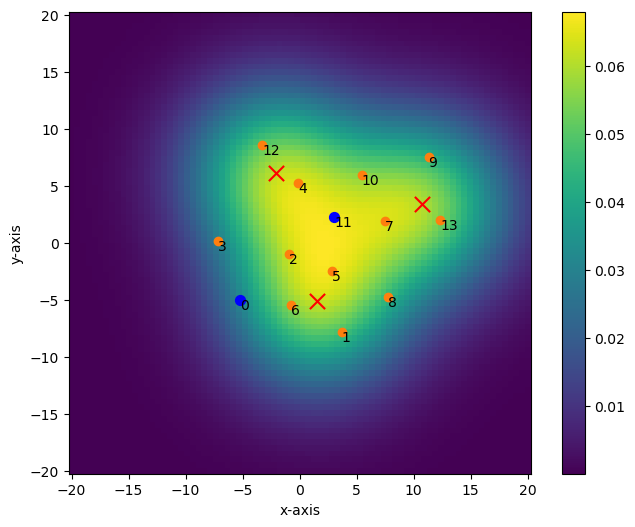

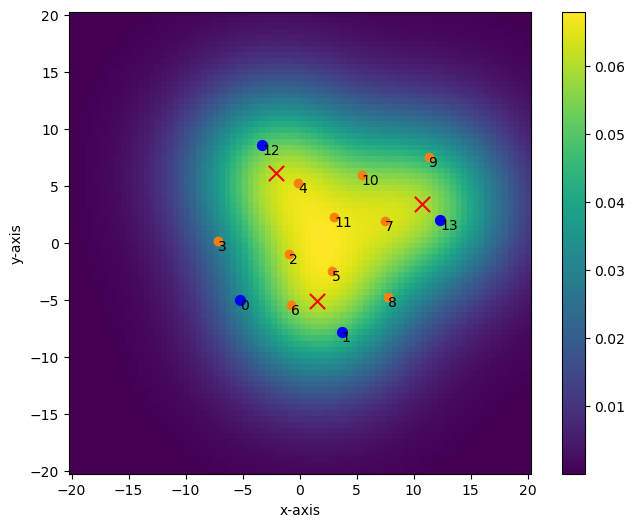

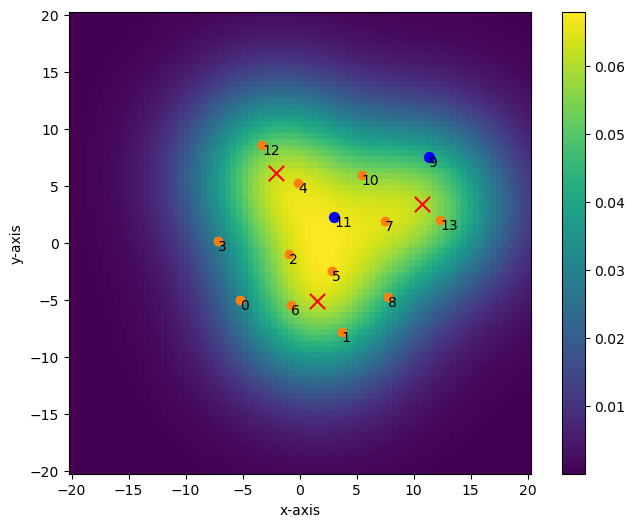

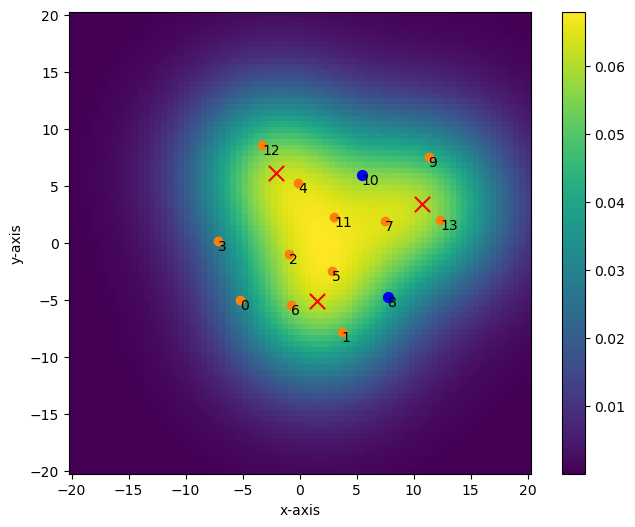

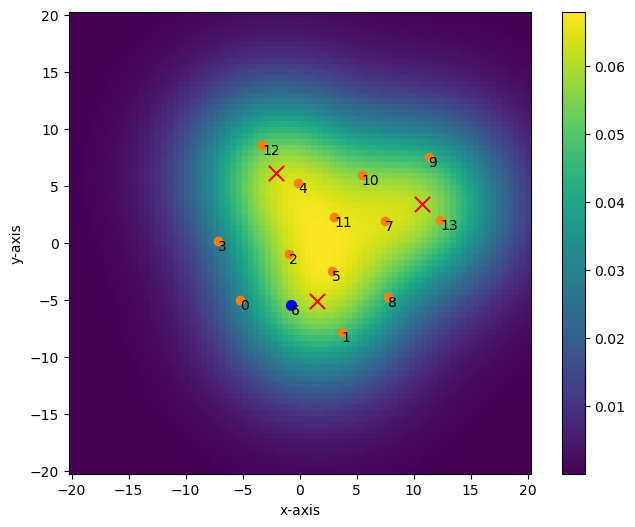

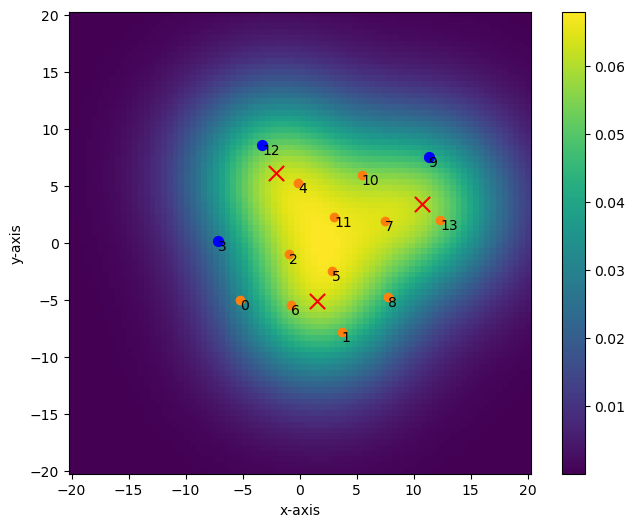

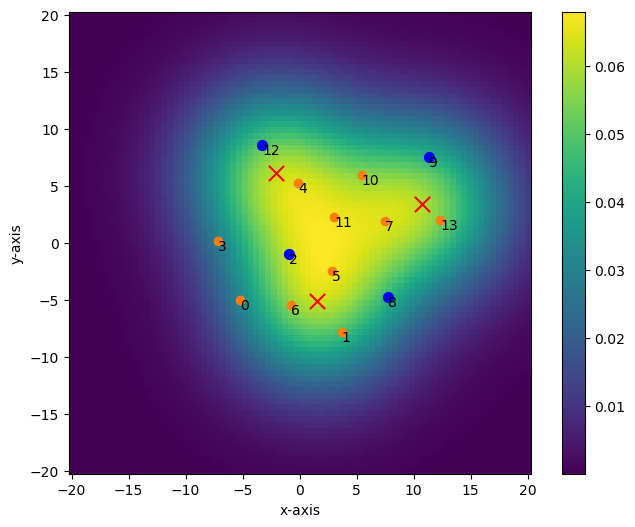

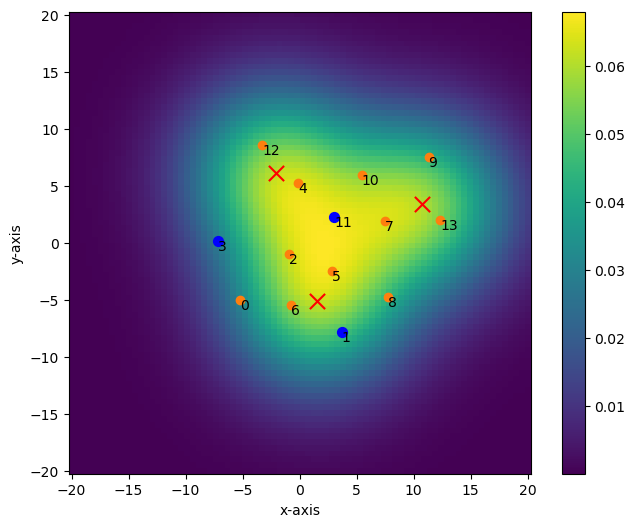

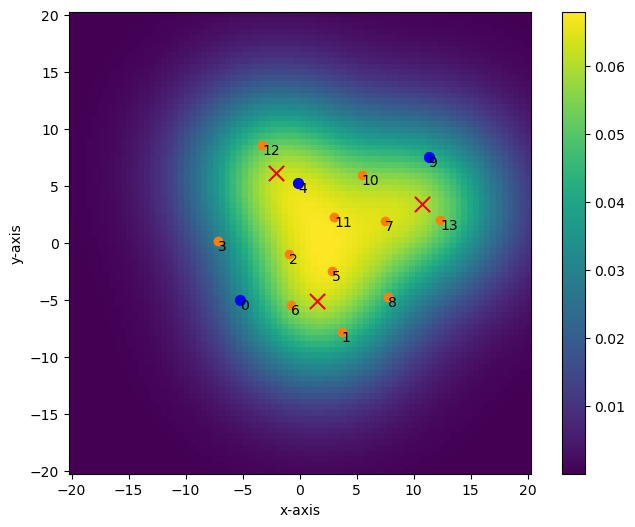

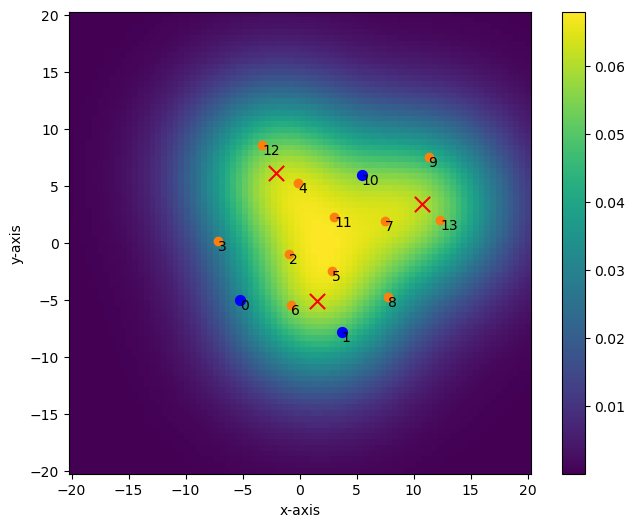

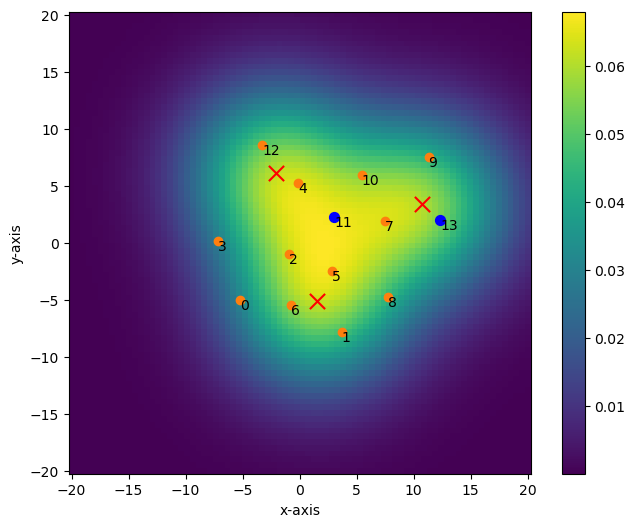

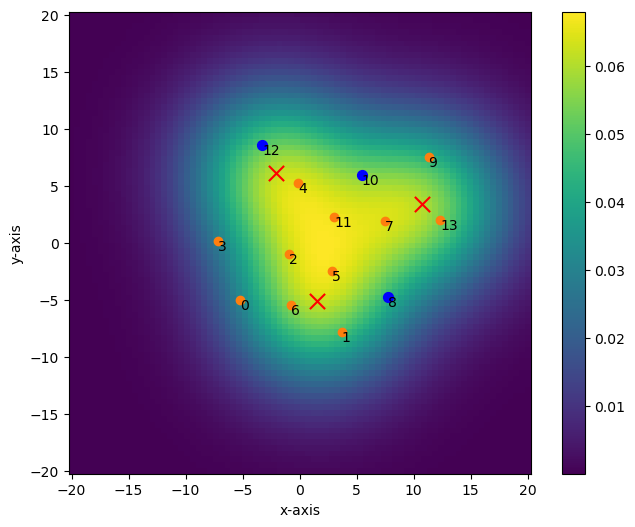

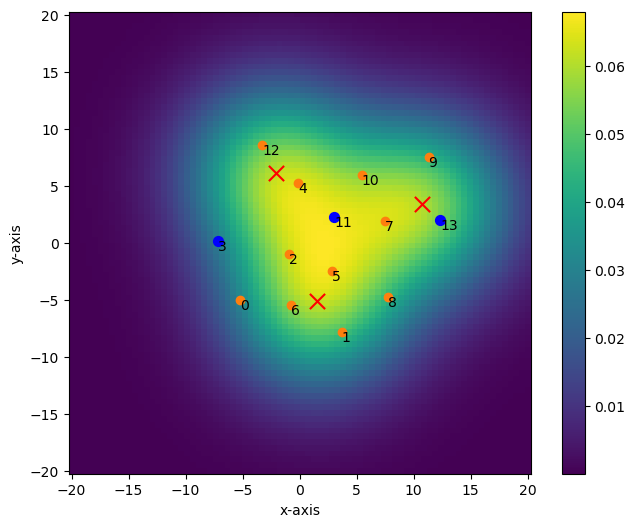

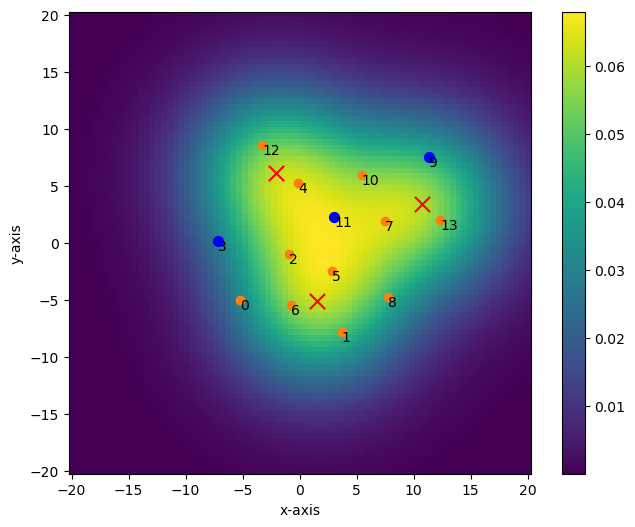

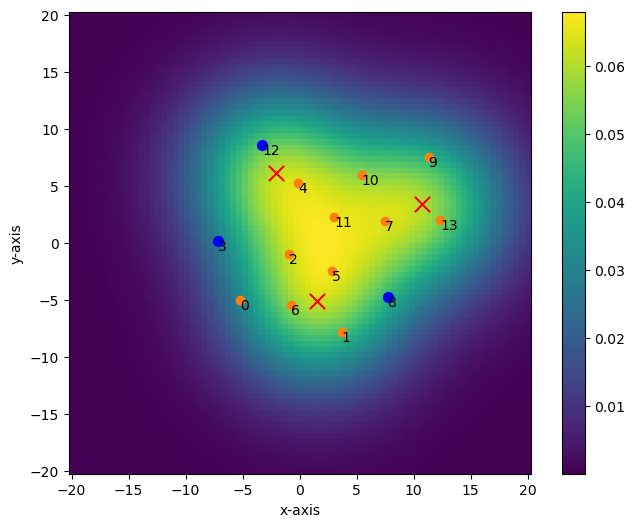

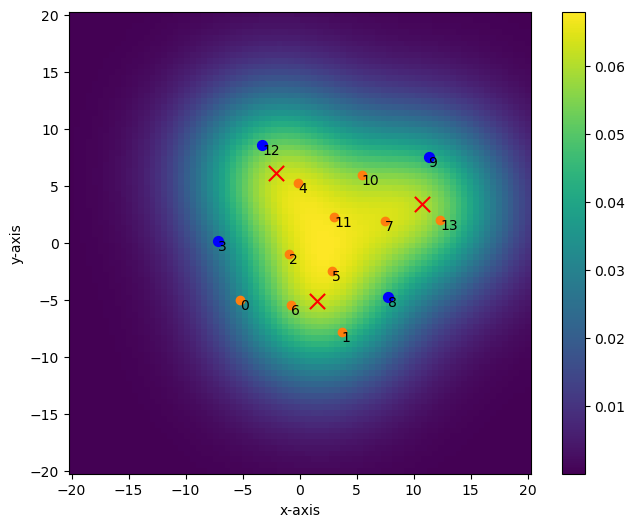

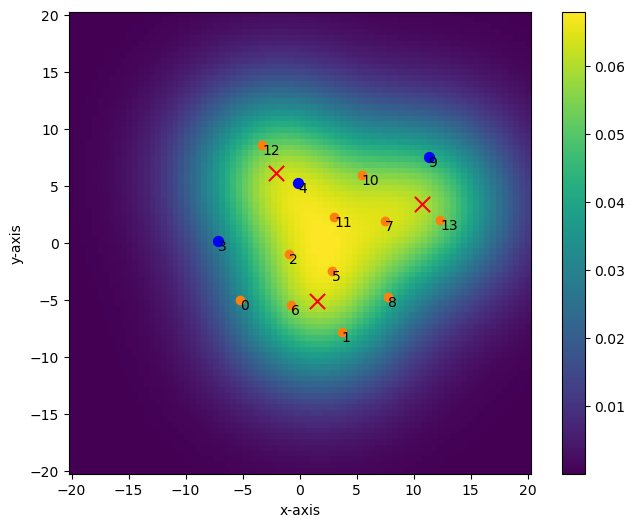

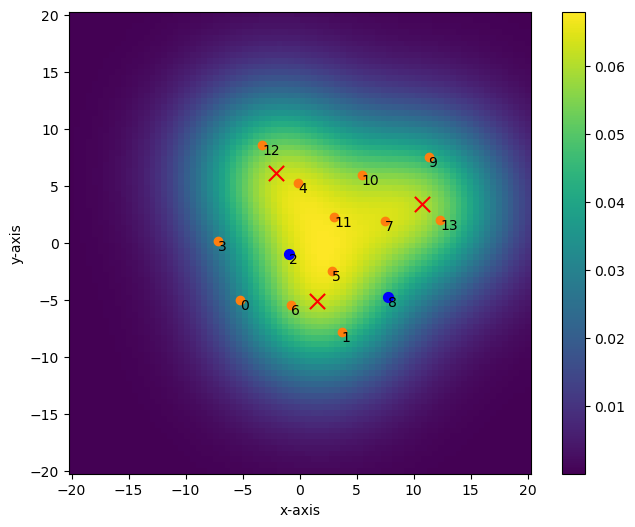

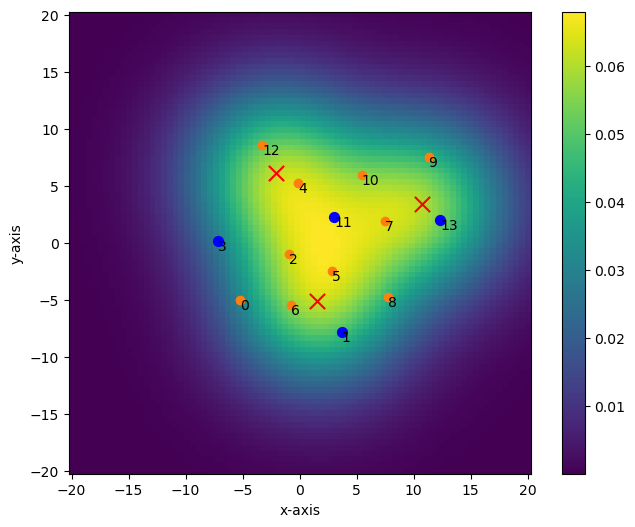

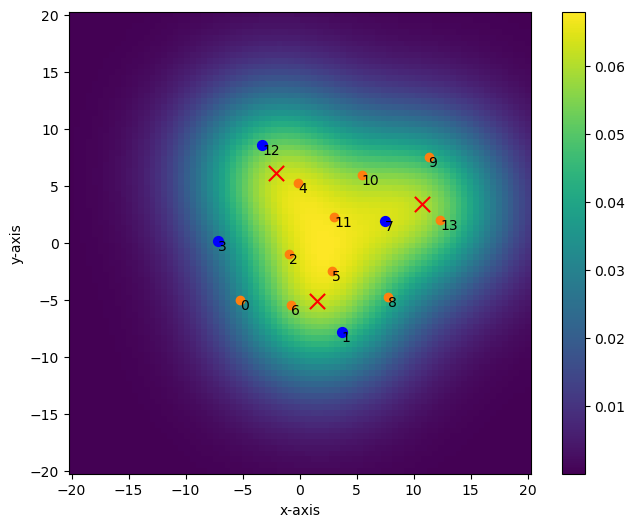

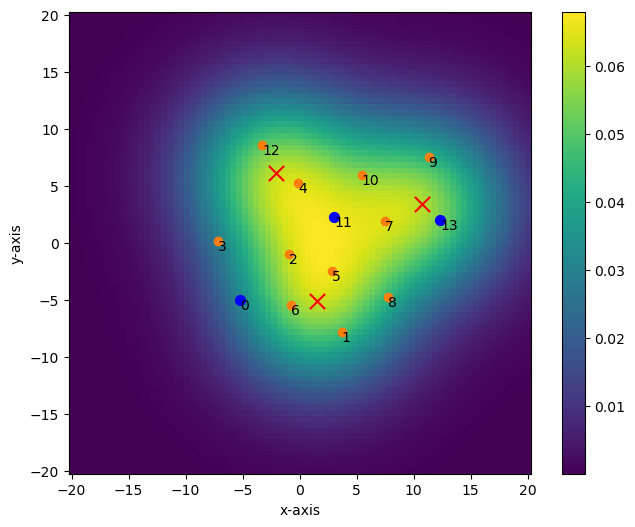

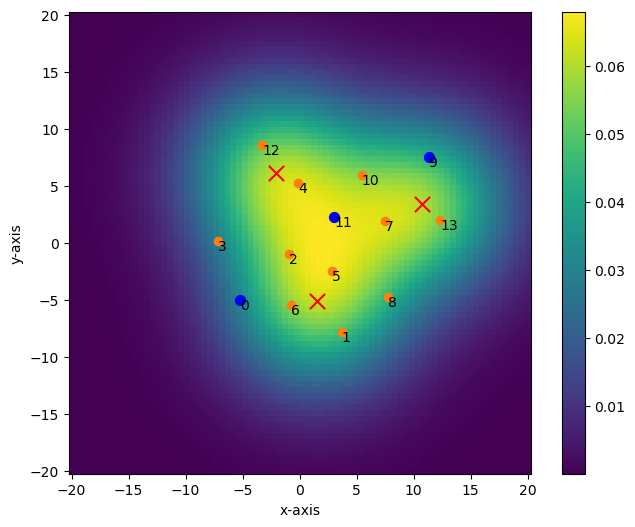

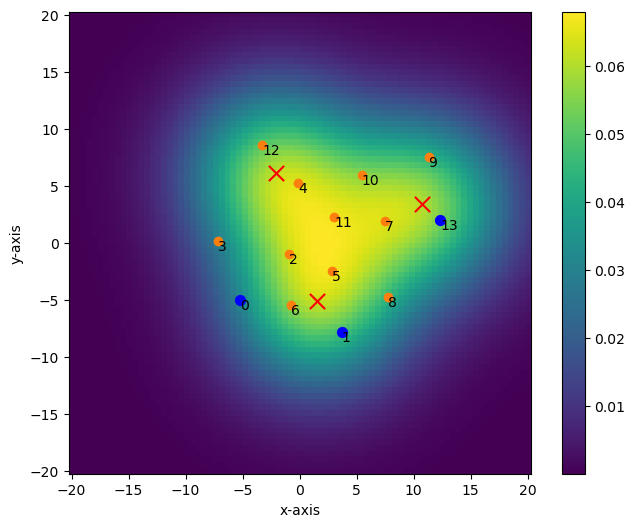

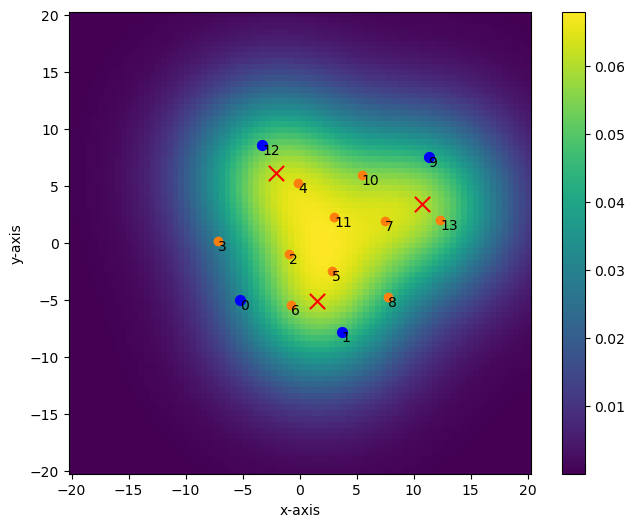

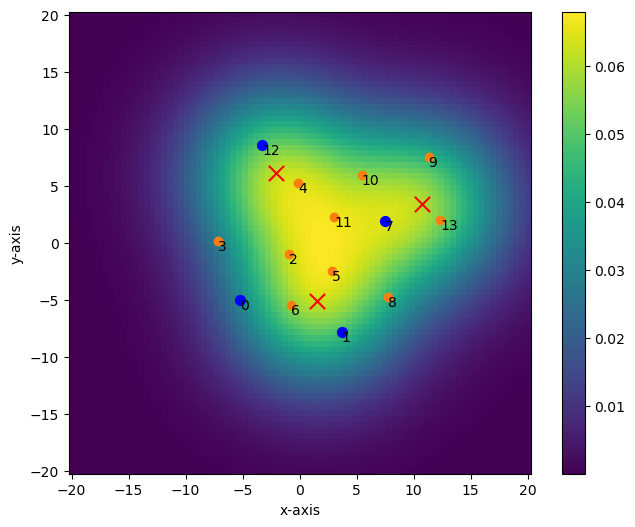

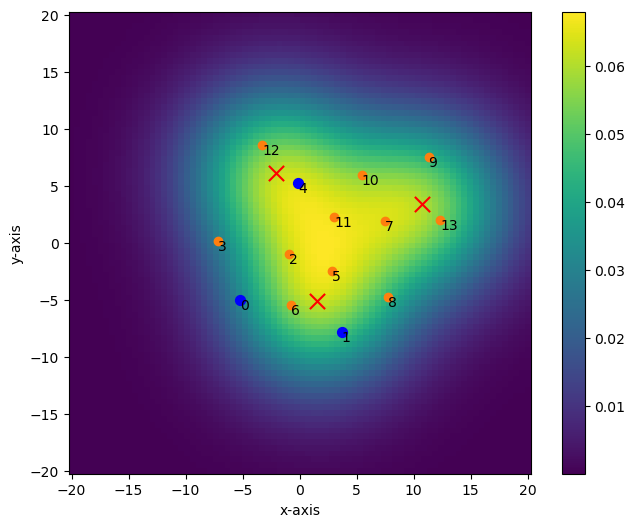

In [6]:
# Visualize solutions as blue dots
for bitstring in samples.keys():
    if '1' not in bitstring:
        continue
    coords = np.array([c for i,c in enumerate(canvas._lattice._coords) if int(bitstring[i])])
    fig, ax = canvas.plotting_objects(draw_centers=True, draw_lattice=True, figsize=(8,6))
    ax.scatter(coords[:,0], coords[:,1], s=50, color='blue')
    plt.show()